In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import gin
import numpy as np
import torch
import pytorch_lightning
from deepgen.models import GruLabeler, LstmLabeler
from deepgen.data import DatasetXY
from deepgen.utils import train_model, test_model
from tqdm import tqdm
import scipy 
import seaborn as sns
import torch.nn.functional as F

from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay


sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_context("paper")

sns.set(rc={'figure.figsize' : (11.7, 8.27),
       'axes.labelsize': 20,
       'axes.titlesize': 20, 
        'figure.dpi':200
       }
)


gin.parse_config_file('configs/big_lstm.gin')
lstm_model = LstmLabeler.load_from_checkpoint(checkpoint_path="o1/lstm-1-layers32.ckpt").eval()
dataset = iter(DatasetXY().test_dataloader())

In [6]:
def myexp(data):
    return scipy.special.softmax(data, axis=-1)

In [18]:
xx = torch.load("o1/const/x_0.pt").numpy()
y_true = torch.load("o1/const/y_true_0.pt")
y_pred = myexp(torch.load("o1/const/1_y_pred_0.pt")).squeeze(0).numpy()

y_true_ohe = F.one_hot(y_true.long(), 32).squeeze(0).numpy()

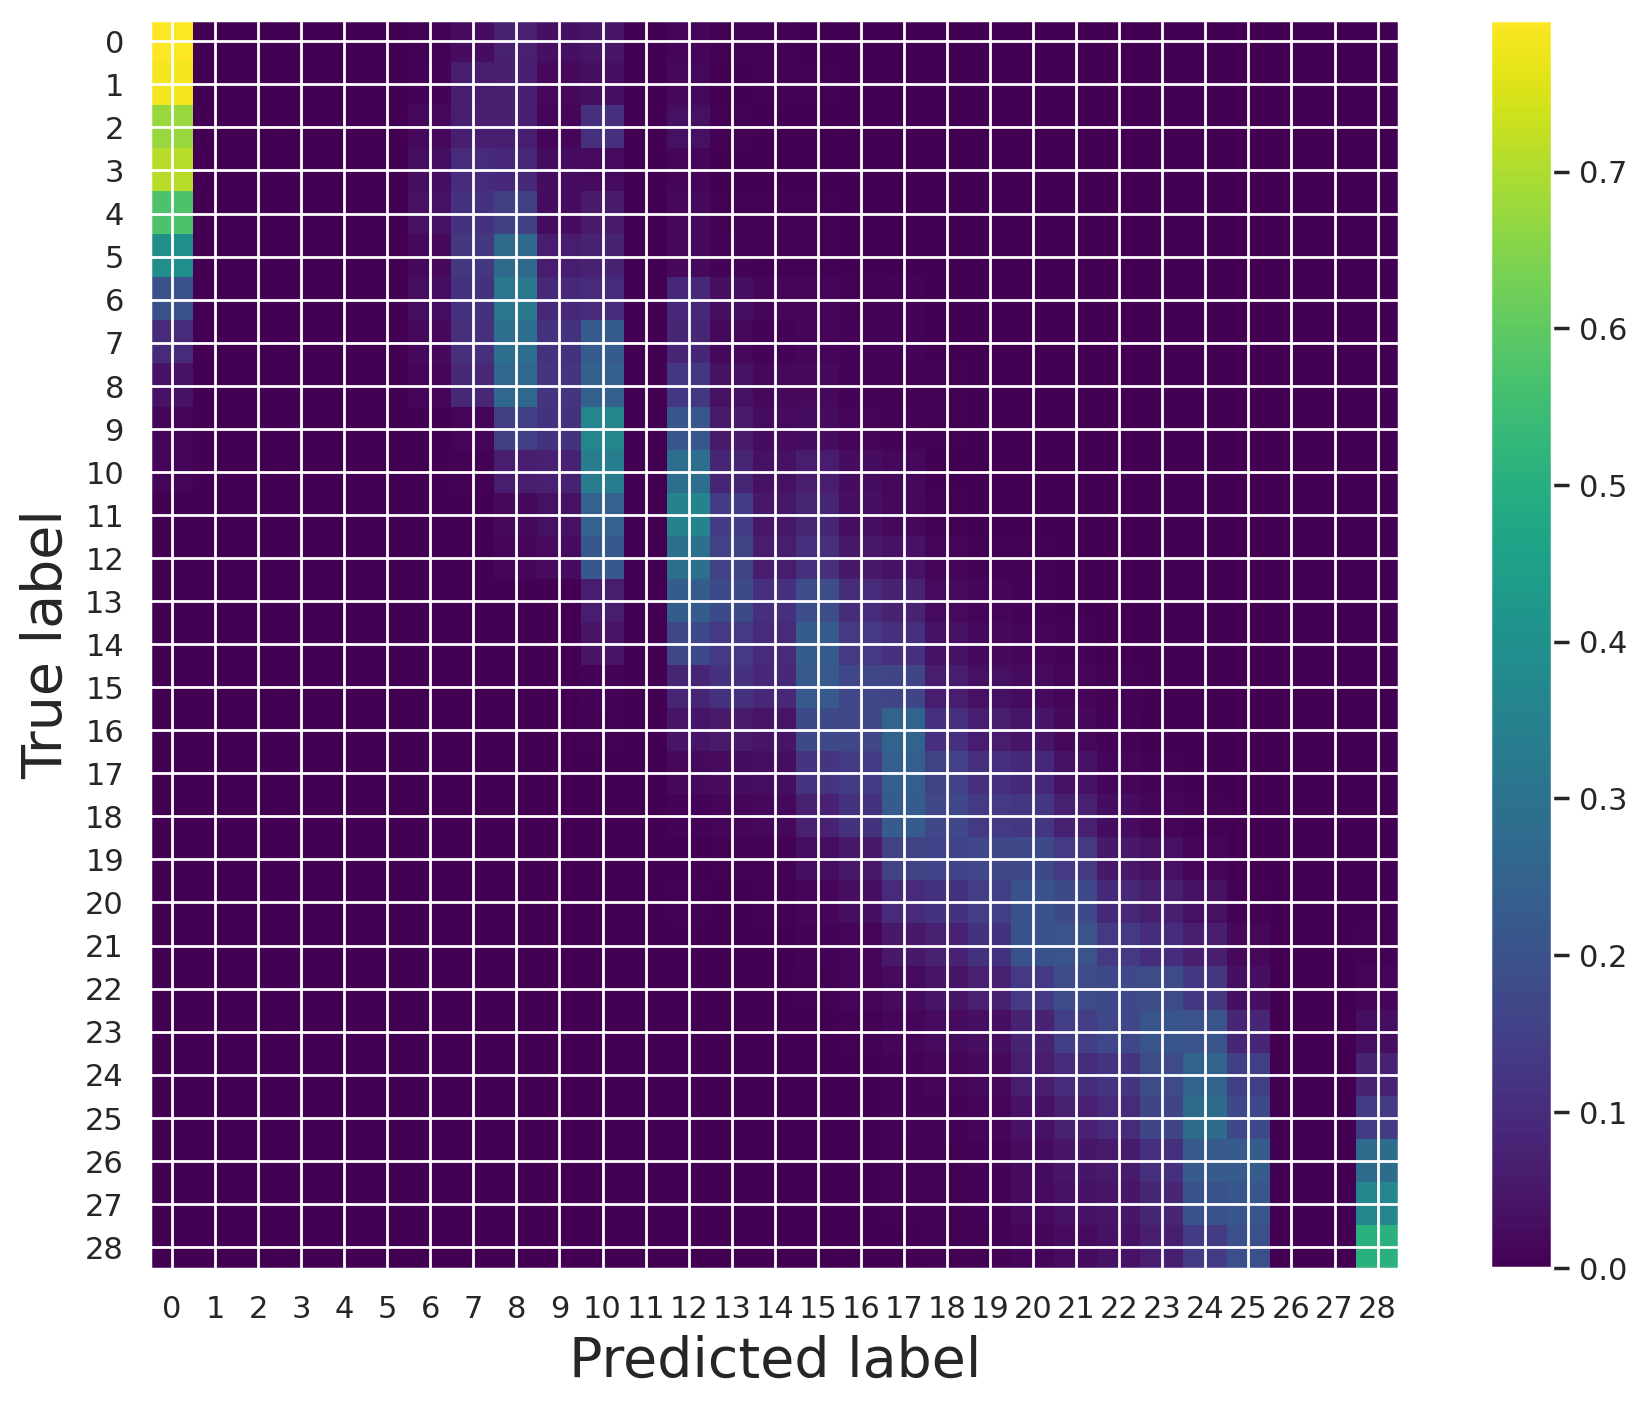

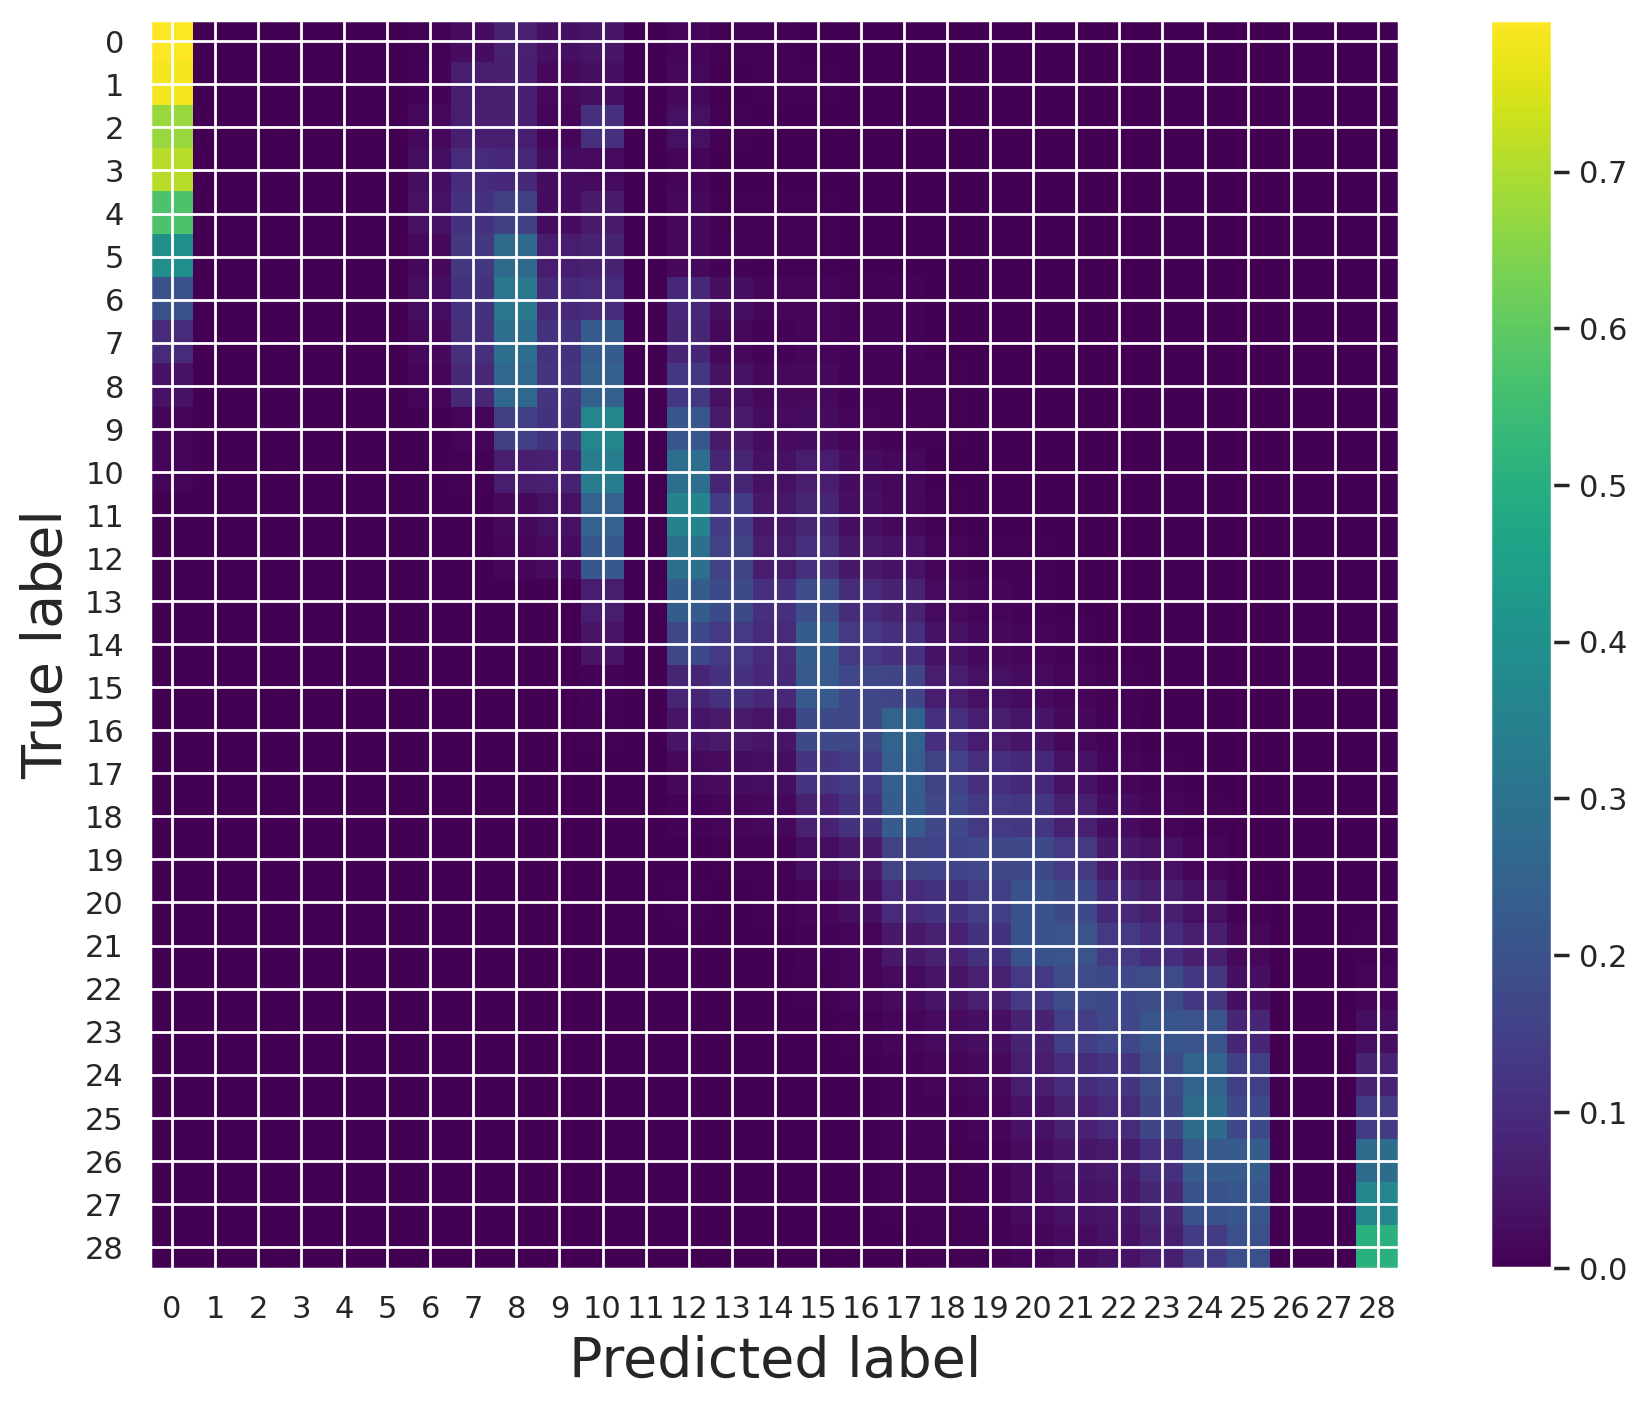

In [53]:
ConfusionMatrixDisplay.from_predictions(y_true.squeeze(0).long(),
                                        np.argmax(y_pred, axis=1).astype(np.long),
                                        include_values=False, 
                                       normalize='true')

In [7]:
%%time
with torch.no_grad():
    x, y_true = next(dataset)
    y_pred = lstm_model(y_true).squeeze(0).numpy()

CPU times: user 1min 21s, sys: 7.41 s, total: 1min 28s
Wall time: 1min 6s
CPU times: user 1min 21s, sys: 7.41 s, total: 1min 28s
Wall time: 1min 6s
CPU times: user 1min 21s, sys: 7.41 s, total: 1min 28s
Wall time: 1min 6s


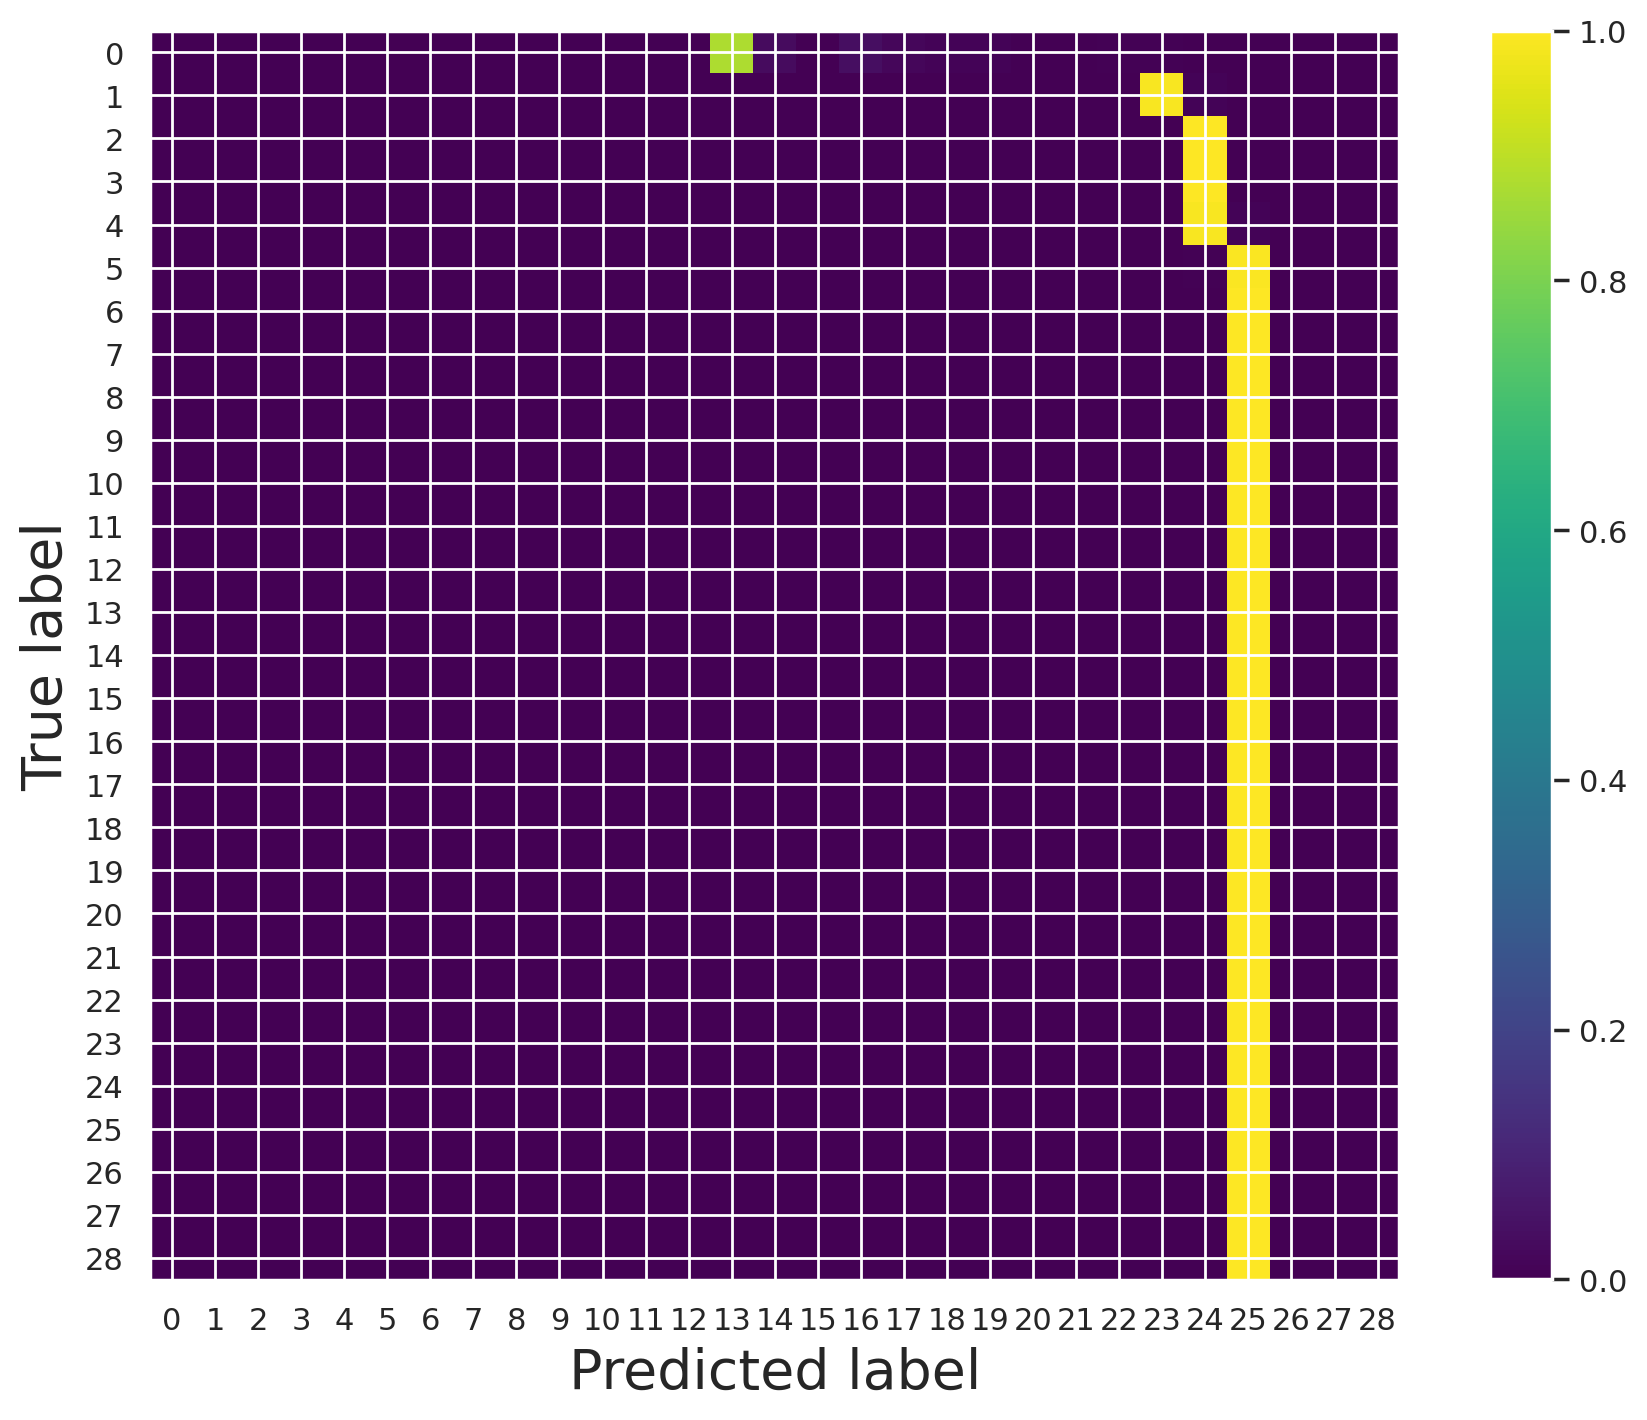

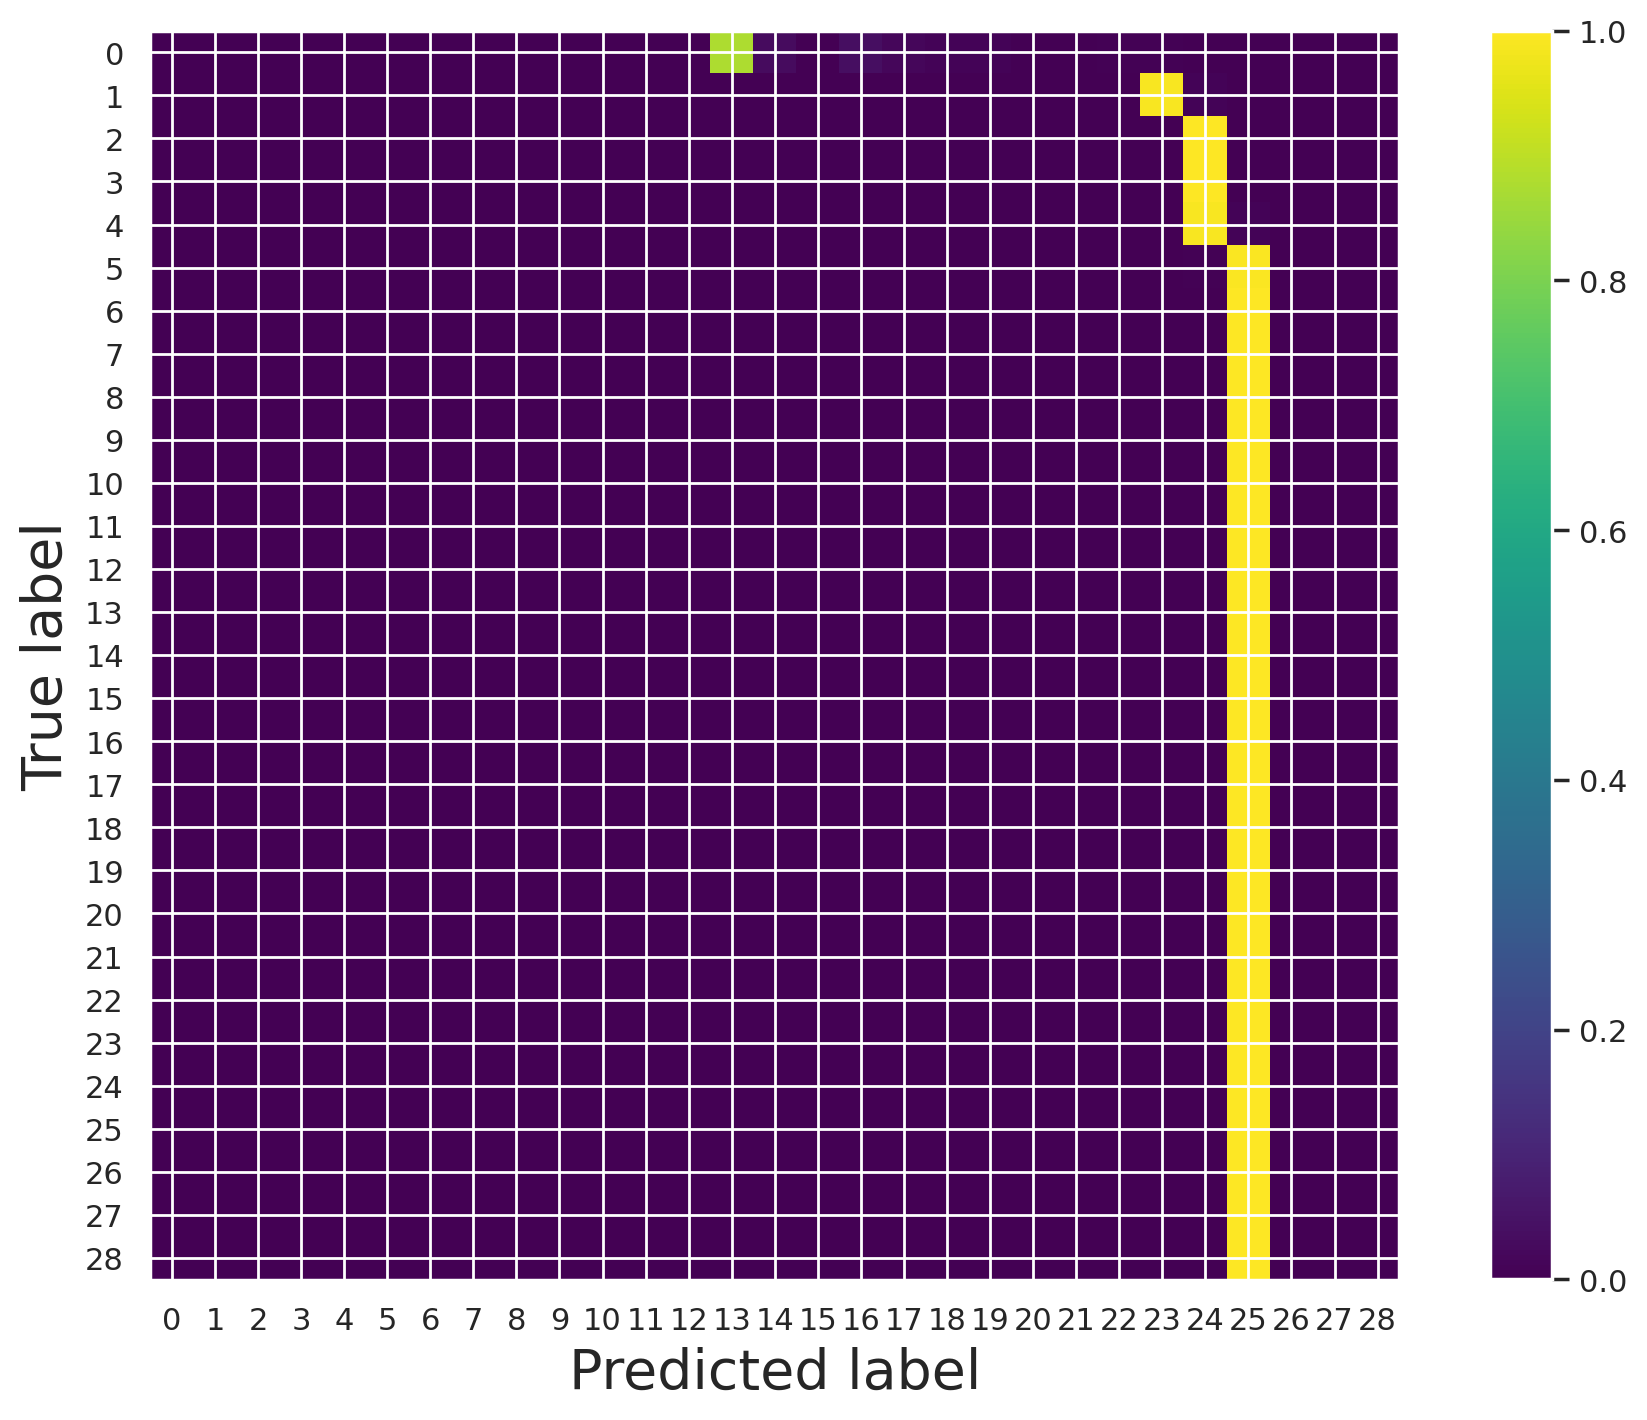

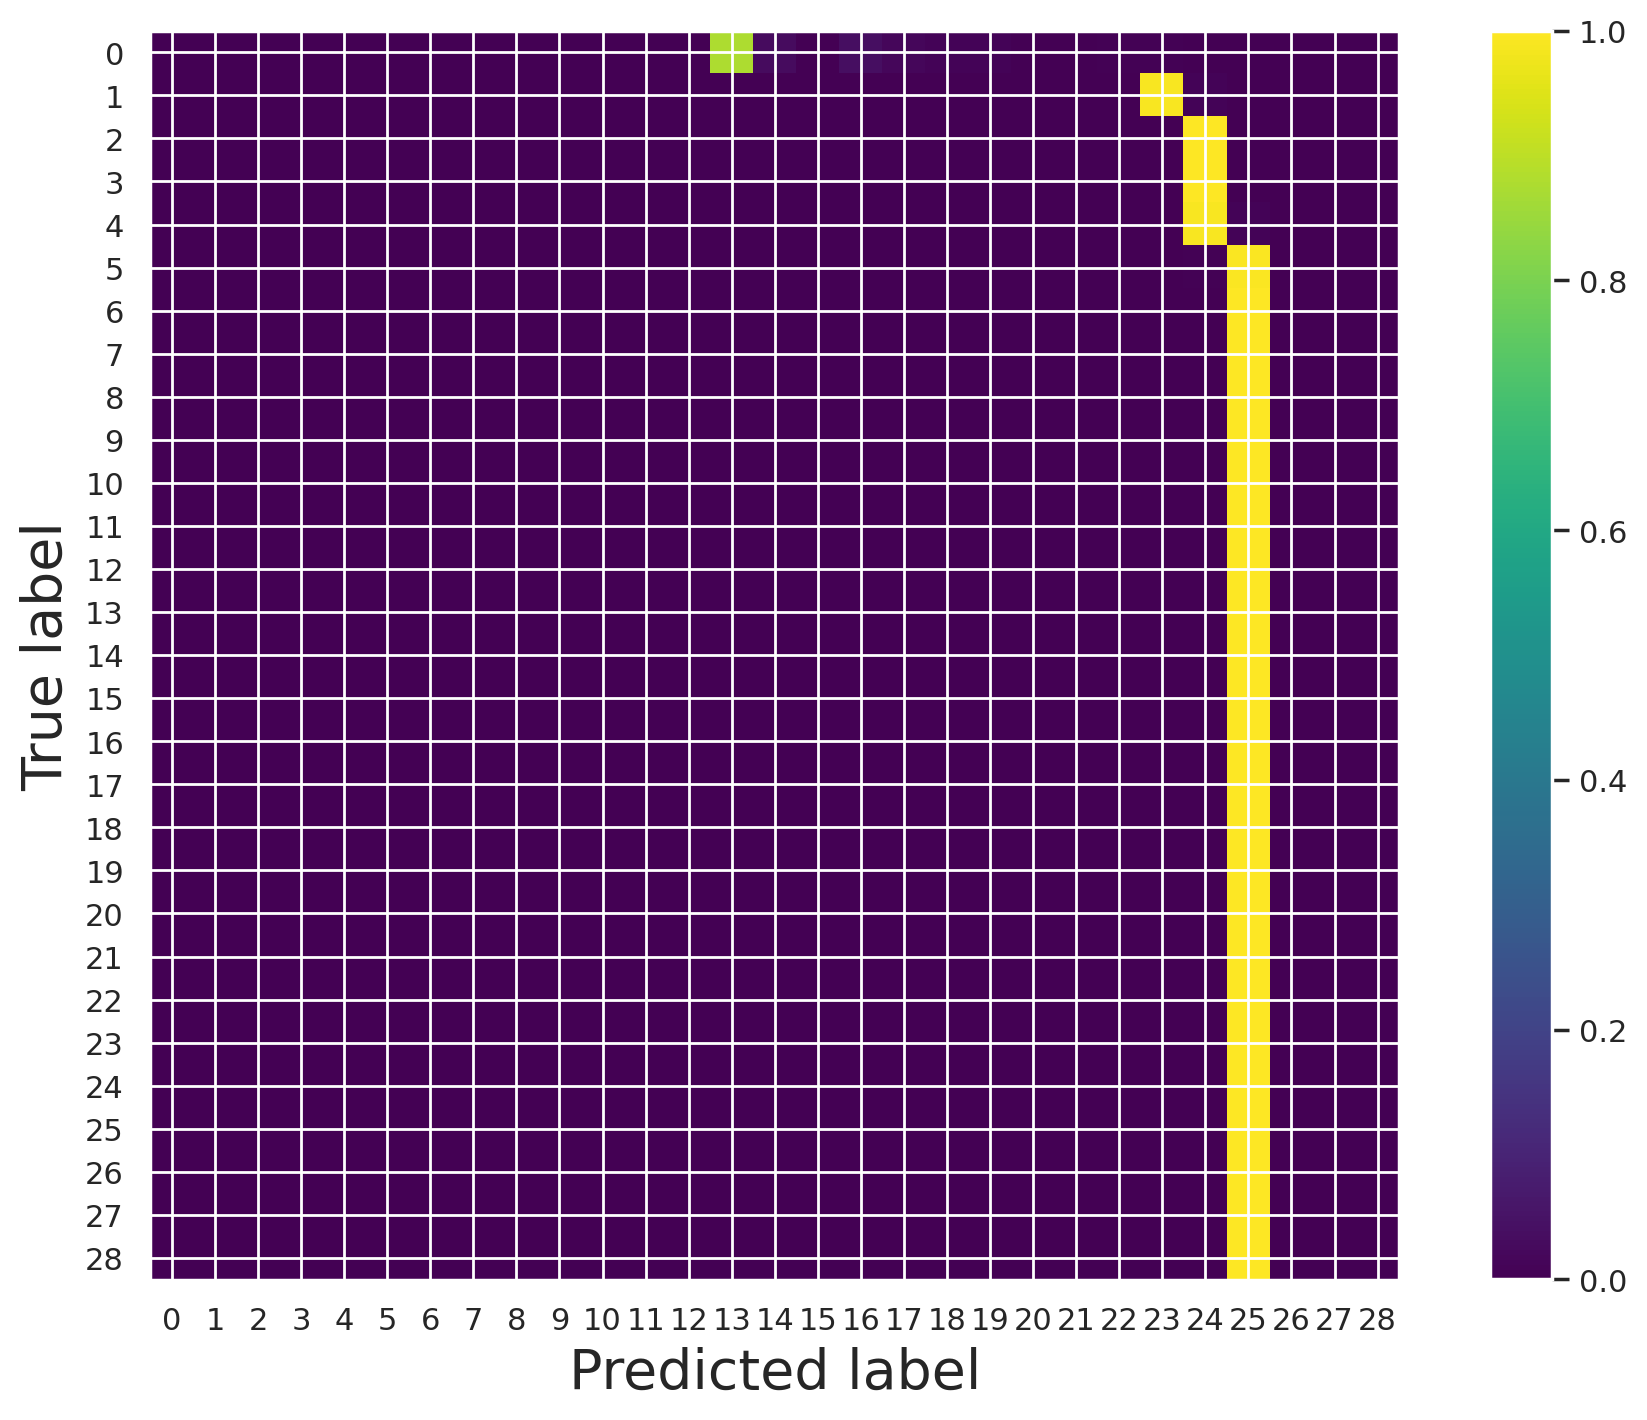

In [8]:
ConfusionMatrixDisplay.from_predictions(y_true.squeeze(0).long(),
                                    np.argmax(myexp(y_pred), axis=1).astype(np.long),
                                    include_values=False, 
                                   normalize='true')

In [12]:
def plot_heatmap(y_pred, y_true, length):
    sns.set(rc={'figure.figsize' : (11.7, 8.27),
           'axes.labelsize': 20,
           'axes.titlesize': 20, 
            'figure.dpi':100
           }
       )
    ax = sns.heatmap(y_pred[:length].T, cmap="viridis", yticklabels=5, xticklabels=1000)
    ax.plot(y_true[0][:length], c='red')
    _ = ax.set(xlabel='Genome wide', ylabel='Coalescent time')
    #ax.set_ylim([23, 0])
    plt.show()

In [13]:
y_pred.shape

(300000, 32)

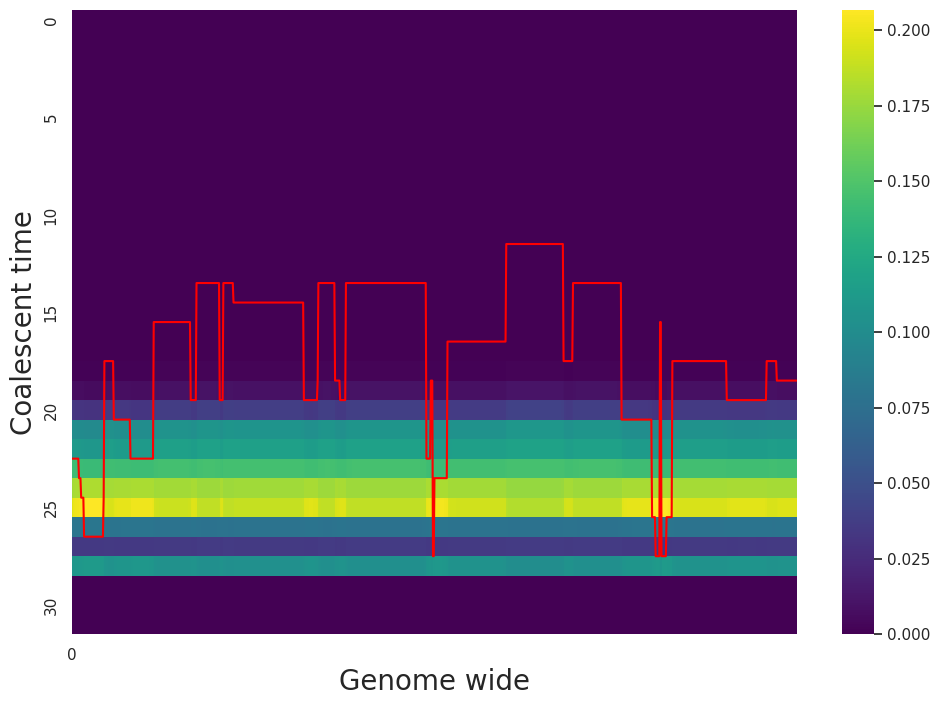

In [17]:
plot_heatmap(myexp(y_pred), y_true, 1000)

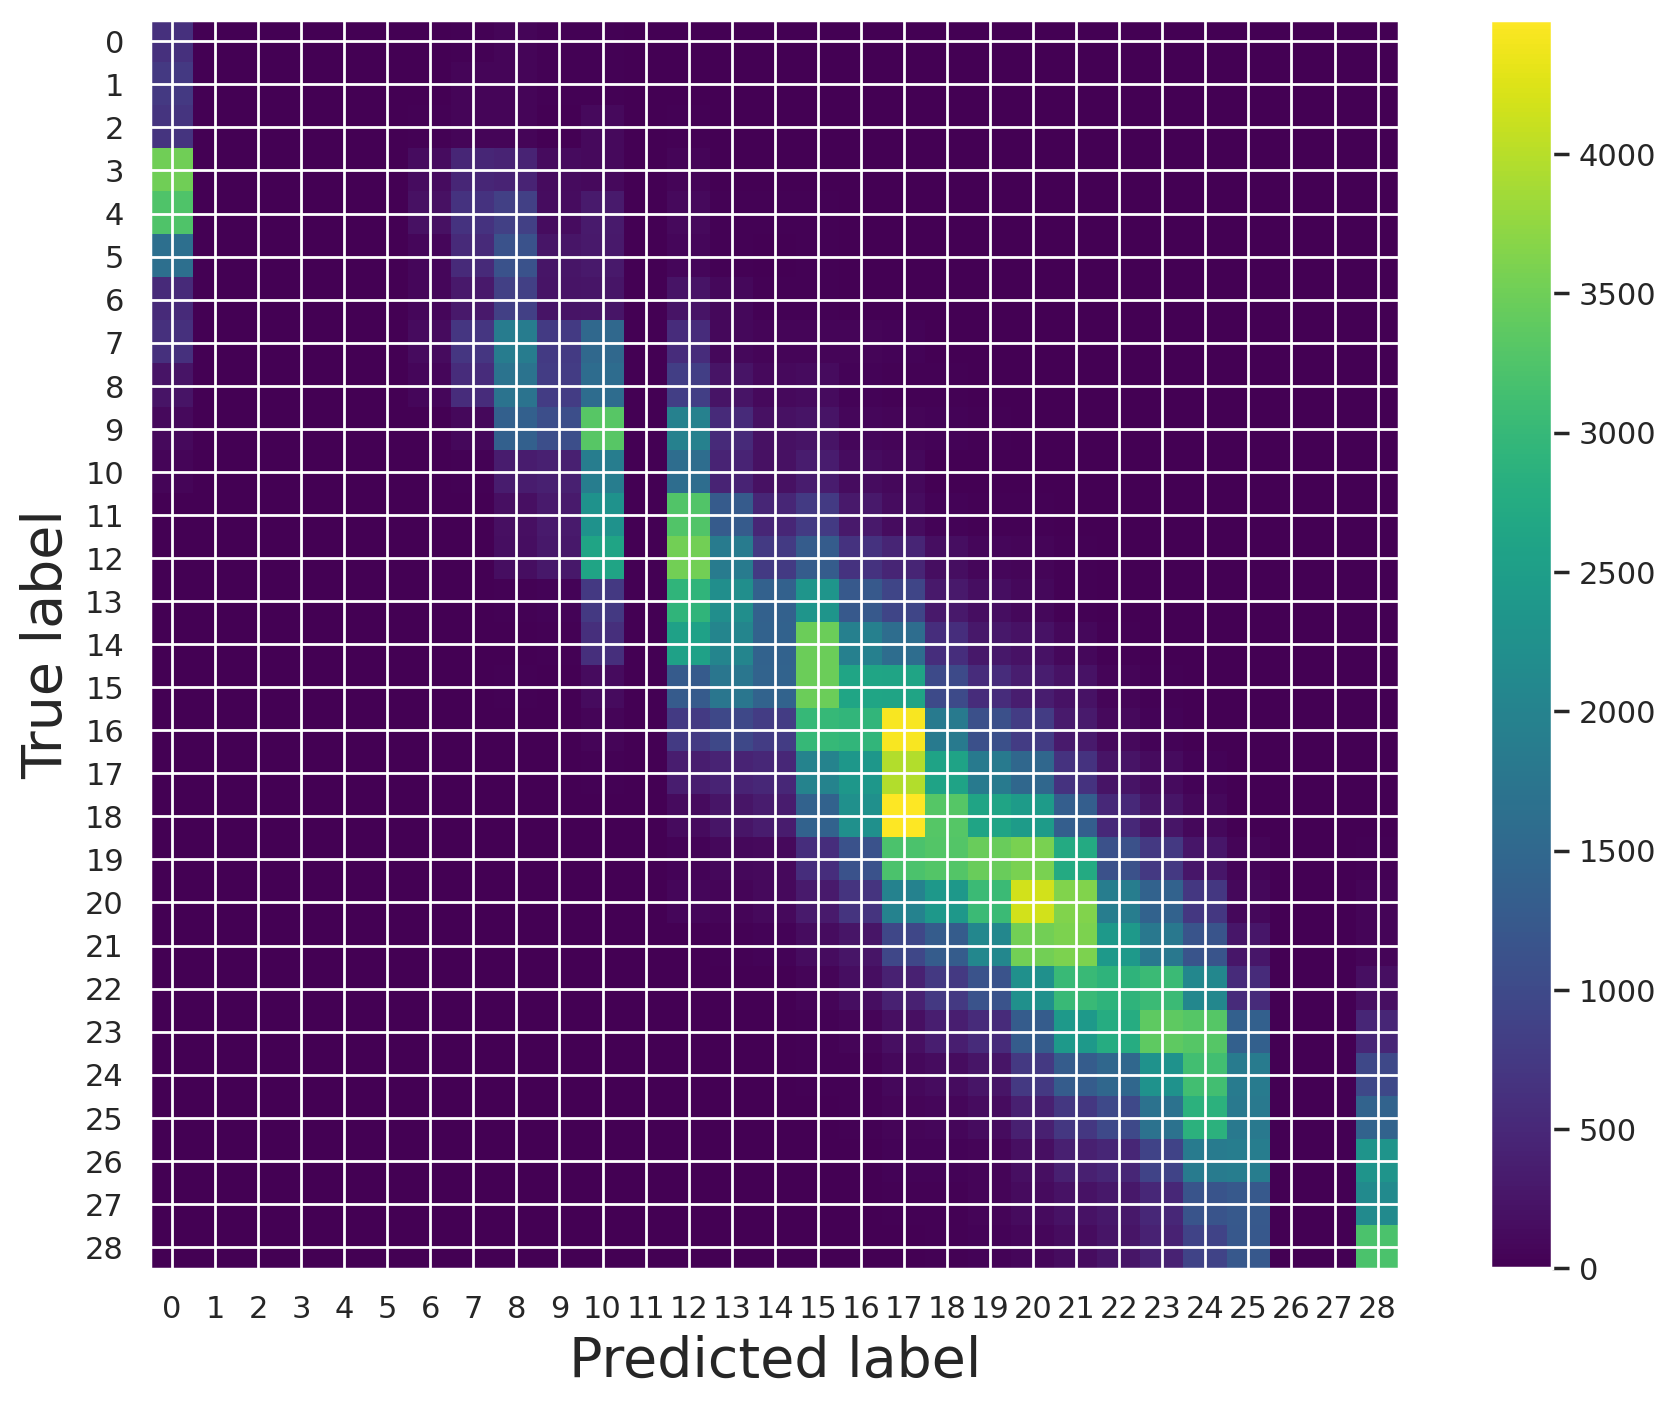

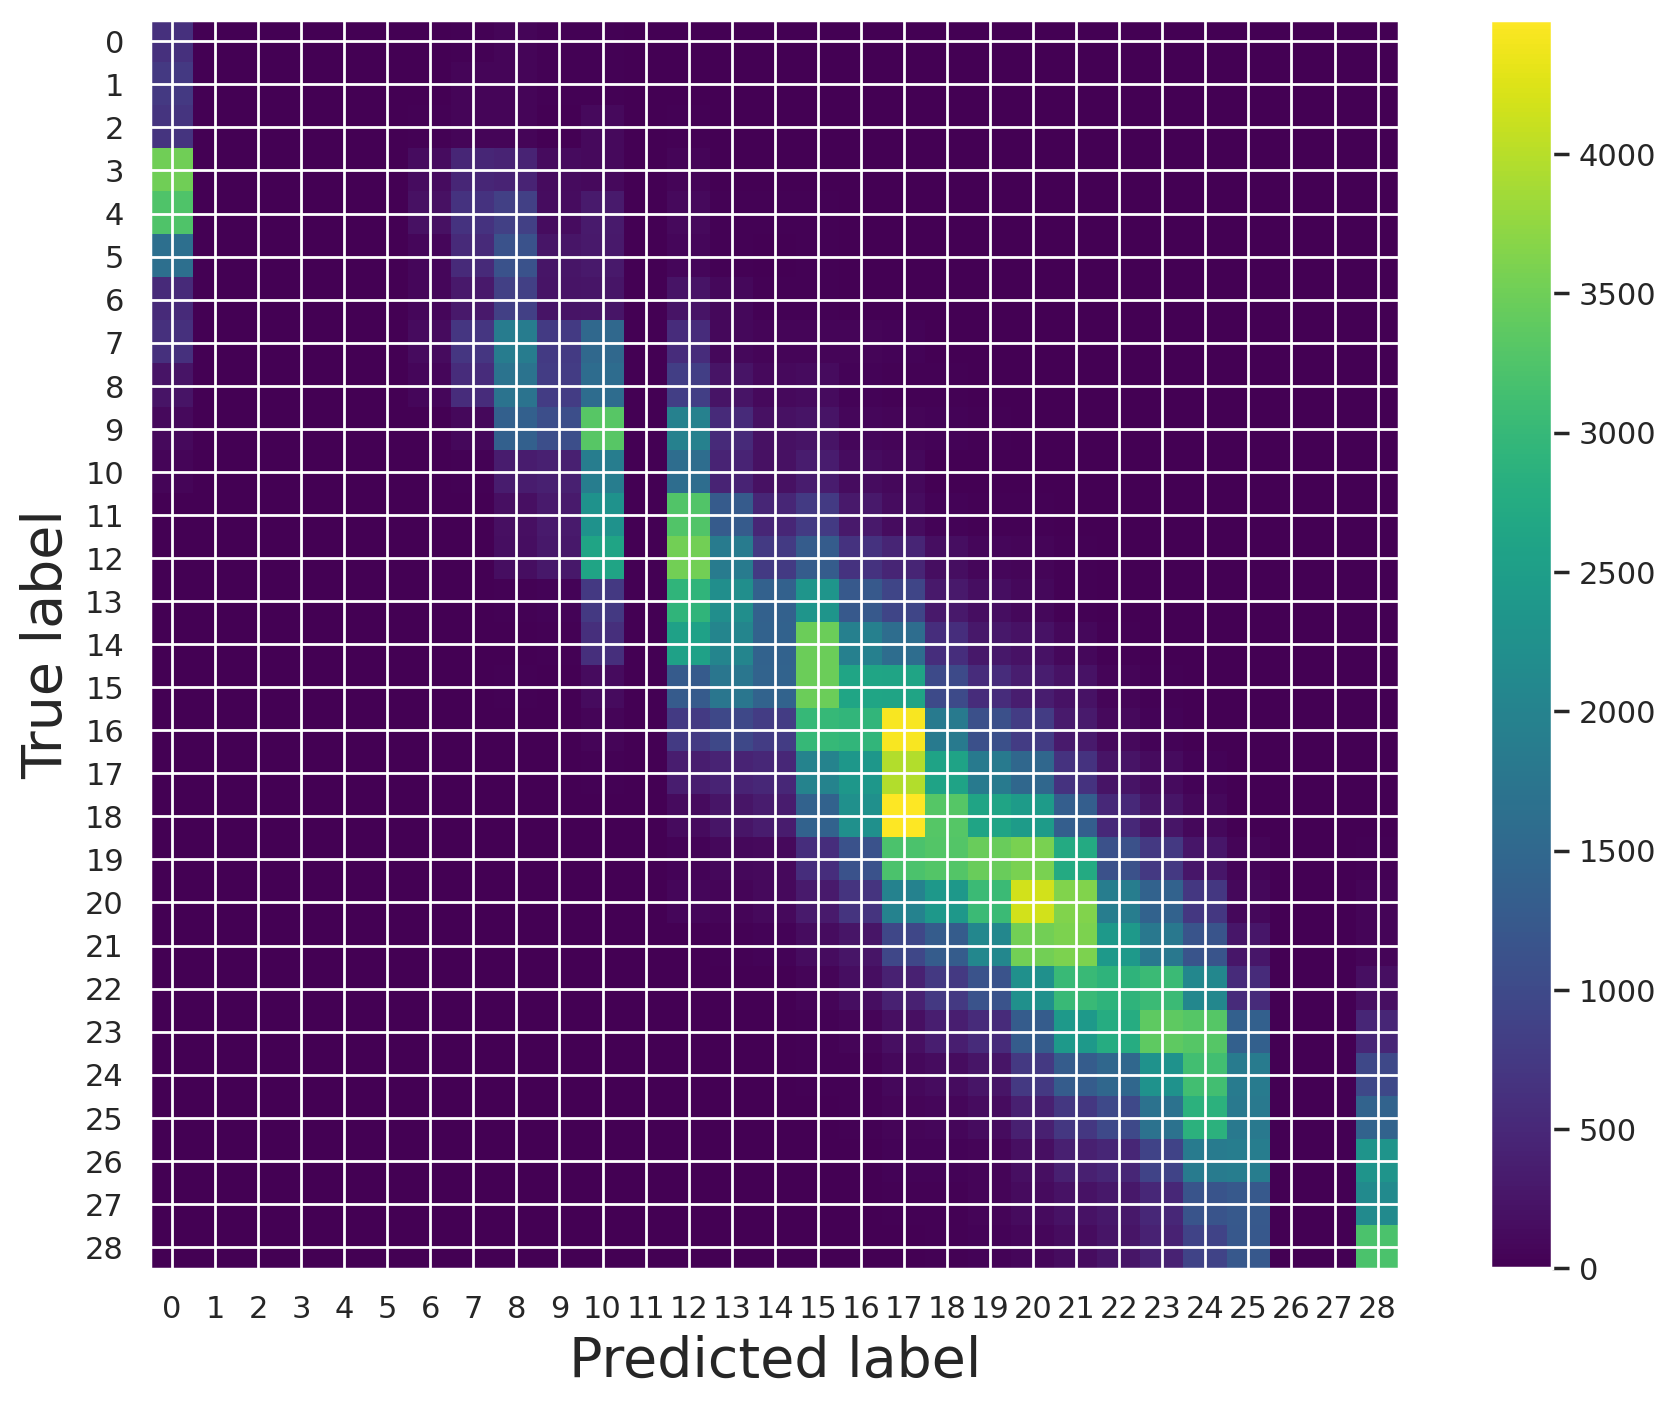

In [50]:
ConfusionMatrixDisplay.from_predictions(y_true.squeeze(0).long(), np.argmax(y_pred, axis=1).astype(np.long), include_values=False)

In [29]:
np.argmax(y_pred[:, 0], axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

AxisError: axis 1 is out of bounds for array of dimension 1

In [36]:
a = confusion_matrix(y_true.squeeze(0), np.argmax(y_pred, axis=1))

In [38]:
a.shape

(29, 29)

(29, 29)

In [21]:
y_true_ohe[:, 1].shape

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
count = dict()


for i in range(32):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_pred[:, i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        count[i] = sum(y_true_ohe[:, i])
    except:
        print(i)

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


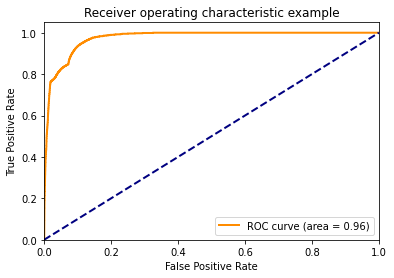

In [9]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [10]:
n_classes = 32

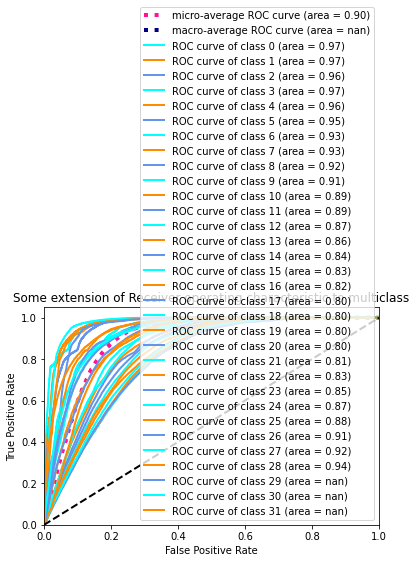

In [11]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(32)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

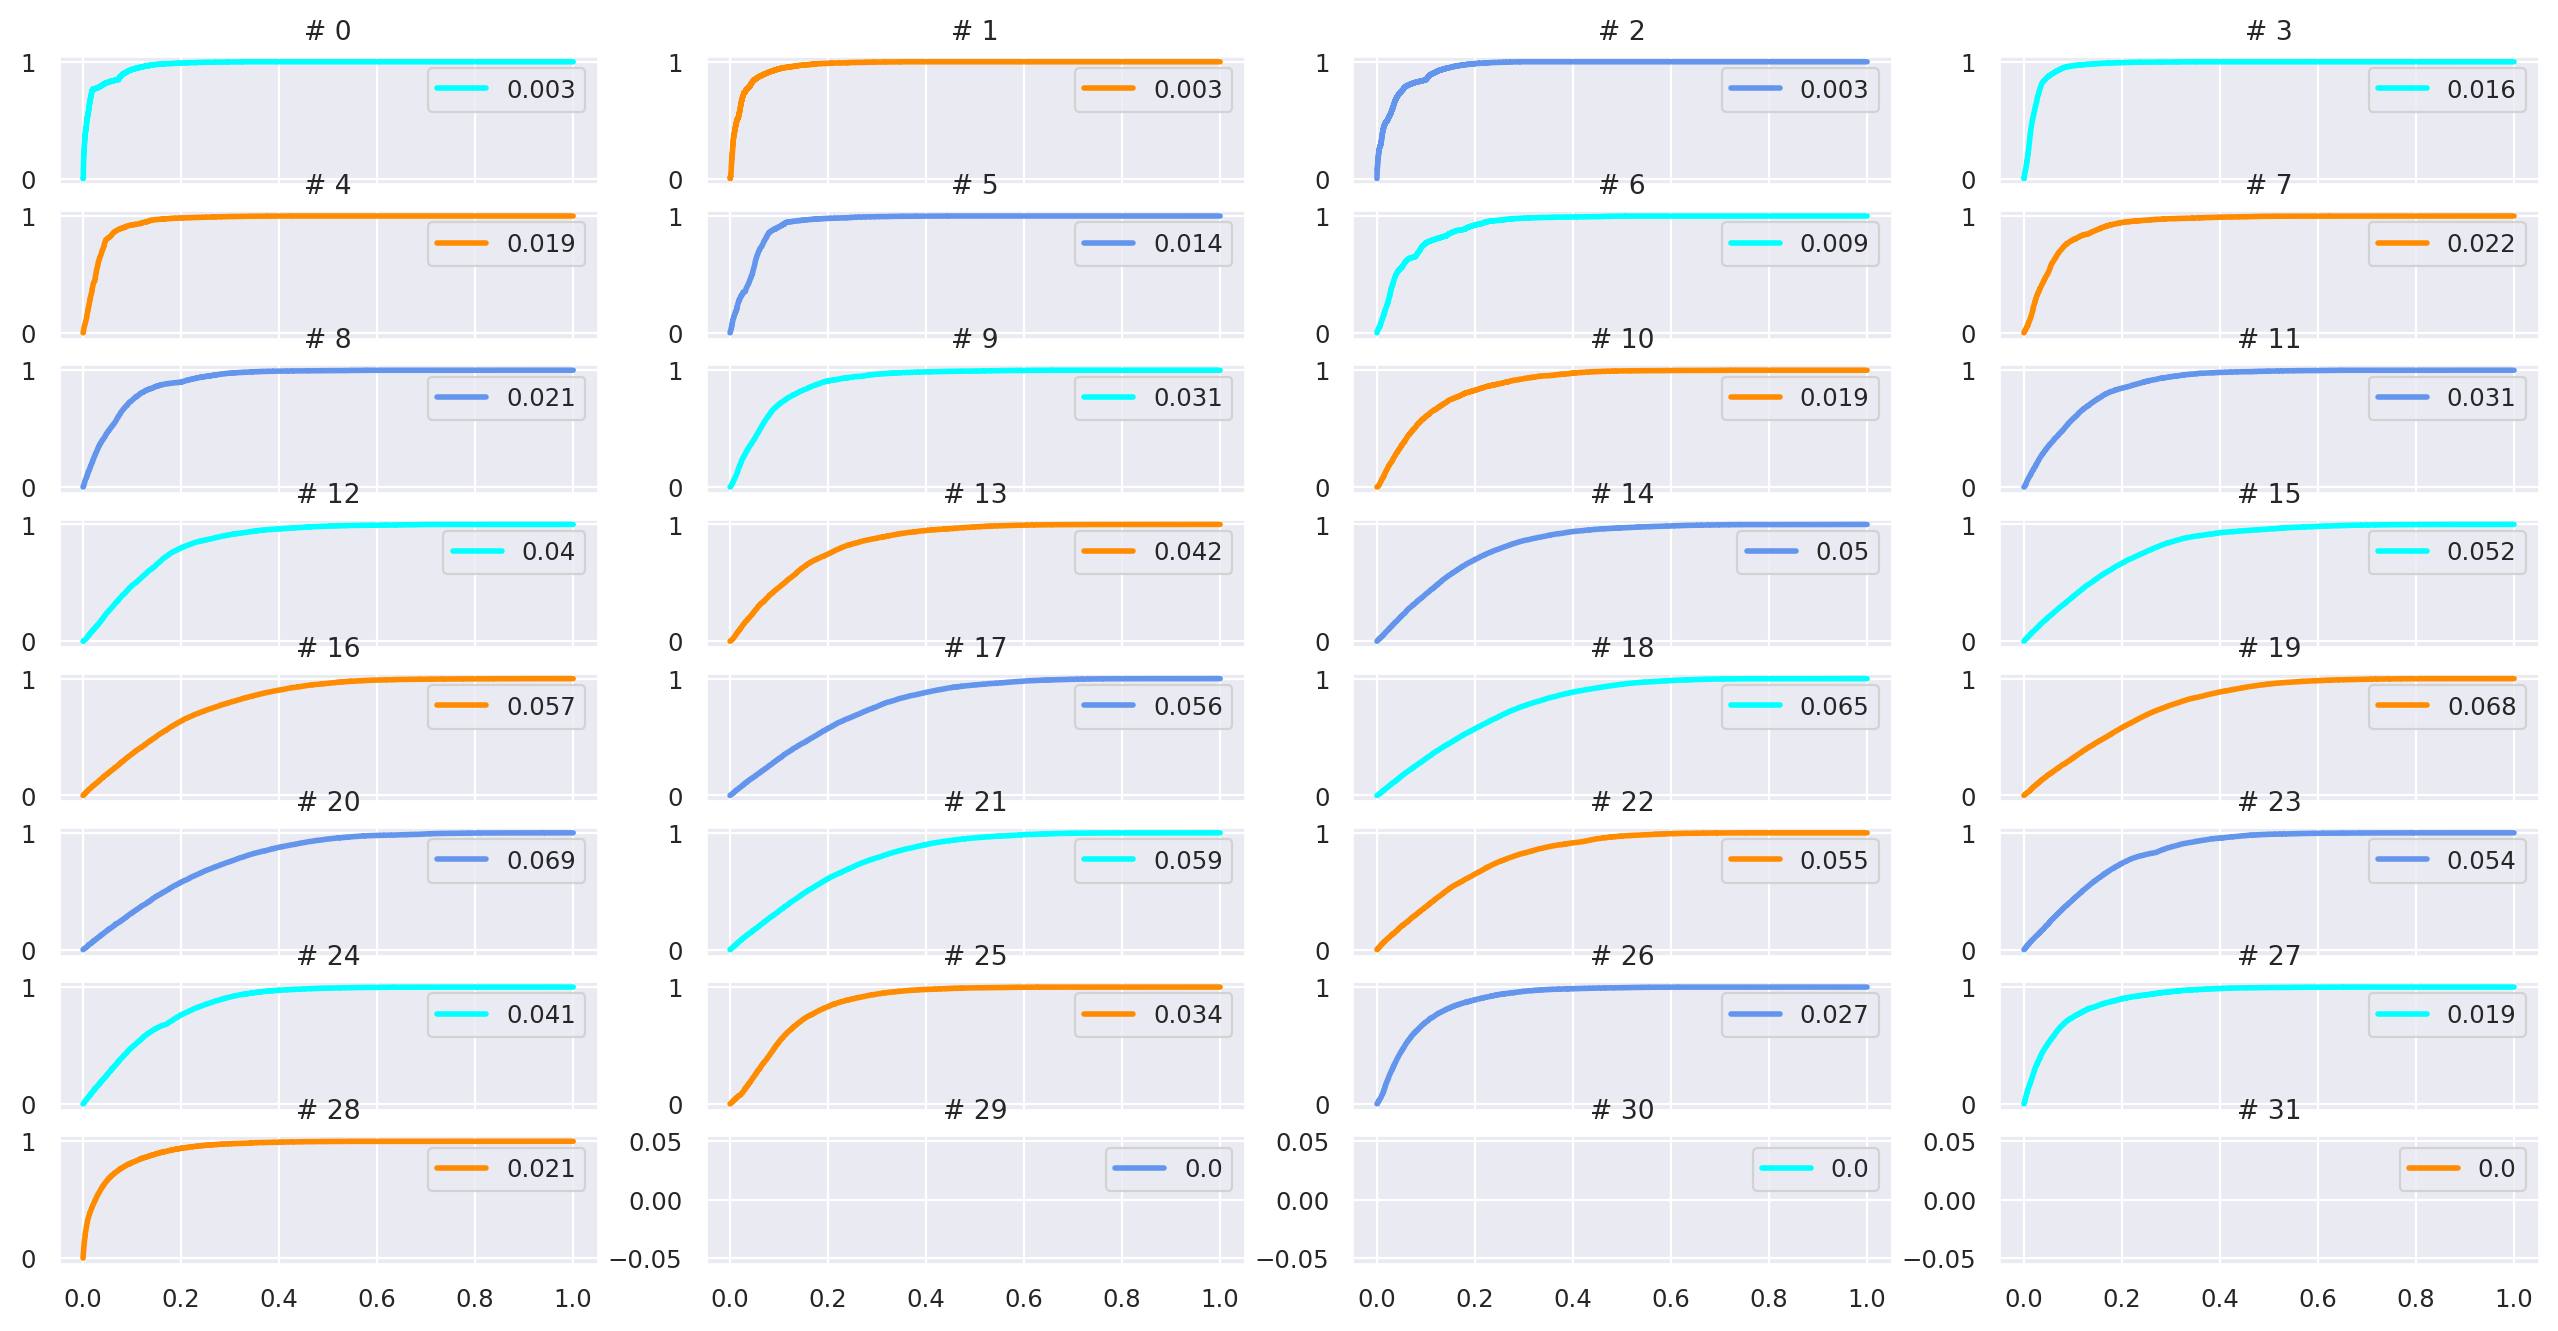

In [12]:
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_context("paper")


fig, axes = plt.subplots(8, 4, sharex=True, figsize=(16,8), dpi=200)

axes = axes.ravel()

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    axes[i].plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= round(count[i] / 300000, 3)
        #label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
    axes[i].title.set_text("# " + str(i))
    axes[i].legend()

No handles with labels found to put in legend.


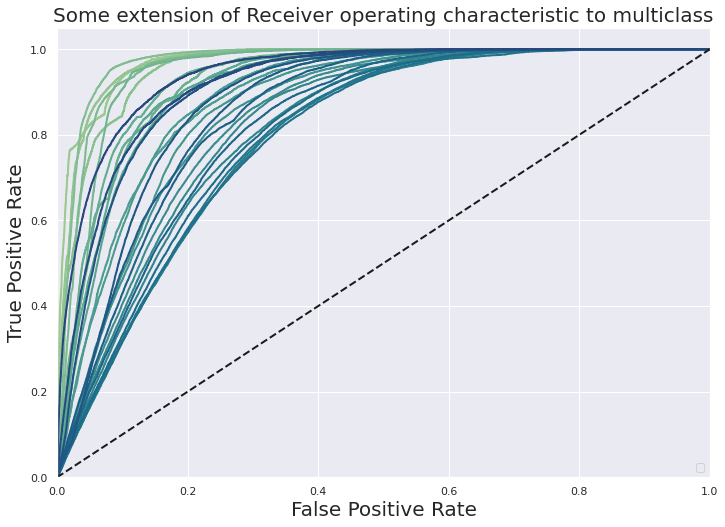

In [13]:
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_context("paper")

sns.set(rc={'figure.figsize' : (11.7, 8.27),
       'axes.labelsize': 20,
       'axes.titlesize': 20
       }
   )


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(32)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = sns.color_palette("crest", 32)
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=lw,
        #label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [67]:
y_true

tensor([[12., 12., 12.,  ...,  9.,  9., 10.]])

In [68]:
torch.where(y_true==25.)

(tensor([0, 0, 0, 0, 0, 0, 0]),
 tensor([72909, 72910, 72911, 72936, 72937, 72938, 72939]))

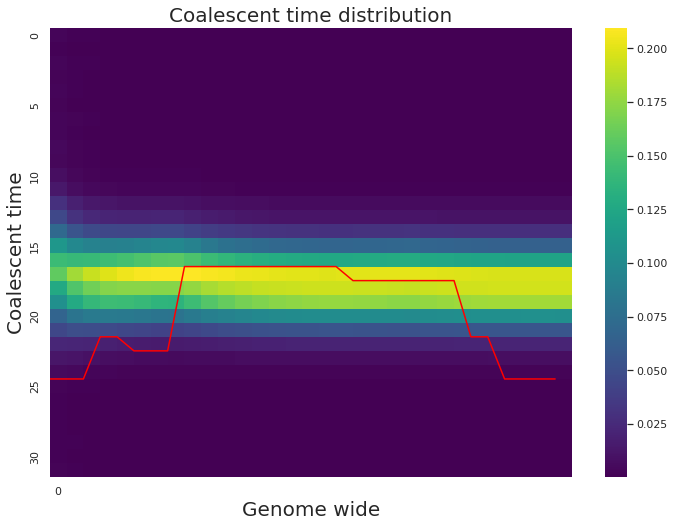

In [49]:
plot_heatmap(y_pred, y_true, 72909, 72940)

In [38]:
def plot_heatmap(y_pred, y_true, s, e):
    sns.set(rc={'figure.figsize' : (11.7, 8.27),
           'axes.labelsize': 20,
           'axes.titlesize': 20
           }
       )
    ax = sns.heatmap(y_pred.squeeze(0)[s:e].T, cmap="viridis", yticklabels=5, xticklabels=1000)
    ax.plot(y_true[0][s:e], c='red')
    _ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")
    plt.show()

In [ ]:
72909

In [ ]:
72939

In [135]:
y_true_ohe = y_true_ohe[72909: 72939]

In [136]:
y_pred = y_pred[72909: 72939]

In [137]:
y_true_ohe.shape

(30, 32)

In [146]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9)
%matplotlib inline


# false positive rate
FPR = []
# true positive rate
TPR = []
# Iterate thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)

# get number of positive and negative examples in the dataset
P = sum(y_true_ohe[:, 25]).item()
N = len(y_true_ohe[:, 25]) - P

# iterate through all thresholds and determine fraction of true positives
# and false positives found at this threshold
for thresh in thresholds:
    FP=0
    TP=0
    thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
    for i in range(len(y_pred[:, 25])):
        if y_pred[:, 25][i] >= thresh:
            if y_true_ohe[:, 25][i] == 1:
                TP = TP + 1
            if y_true_ohe[:, 25][i] == 0:
                FP = FP + 1
    FPR.append(FP/N)
    TPR.append(TP/P)


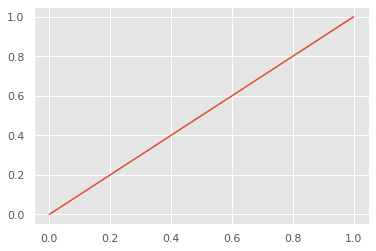

In [147]:
plt.plot(FPR, TPR)

In [145]:
y_true_ohe[:, 25]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1])

In [143]:
y_pred[:, 25]

array([0.00241989, 0.00148864, 0.00094999, 0.00066979, 0.00052929,
       0.00045697, 0.00042038, 0.00040598, 0.00039457, 0.00037726,
       0.00037009, 0.00036634, 0.00036438, 0.00036331, 0.00036262,
       0.00036201, 0.00036152, 0.00036111, 0.00036089, 0.00036114,
       0.00036243, 0.00036557, 0.00036461, 0.00036509, 0.00036525,
       0.0003653 , 0.0003654 , 0.00036556, 0.00036576, 0.00036598],
      dtype=float32)

In [140]:
fpr, tpr, thresholds = roc_curve(y_true_ohe[:, 25], y_pred[:, 25], pos_label=1)

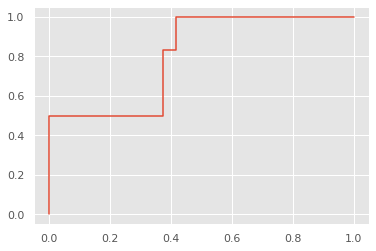

In [141]:
plt.plot(fpr, tpr)

In [124]:
import numpy as np
from sklearn import metrics
scores = np.array([0.8, 0.6, 0.4, 0.2])
y = np.array([1,0,1,0])

#thresholds : array, shape = [n_thresholds] Decreasing thresholds on the decision function used to compute fpr and tpr. 
#thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
#thresholds: array([1.8, 0.8, 0.6, 0.4, 0.2])
#tpr: array([0. , 0.5, 0.5, 1. , 1. ])
#fpr: array([0. , 0. , 0.5, 0.5, 1. ])
metrics.auc(fpr, tpr)
#0.75

0.75

In [8]:
from sklearn.metrics import PrecisionRecallDisplay

In [13]:
y_pred[:, 25].shape

(300000,)

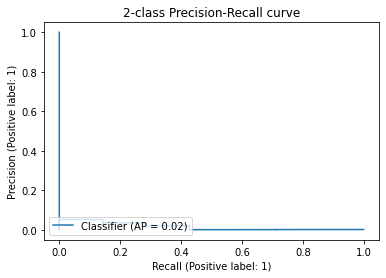

/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/karzymatov/anaconda3/envs/msprime-env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:863: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/karzymatov/a

NameError: name 'lw' is not defined

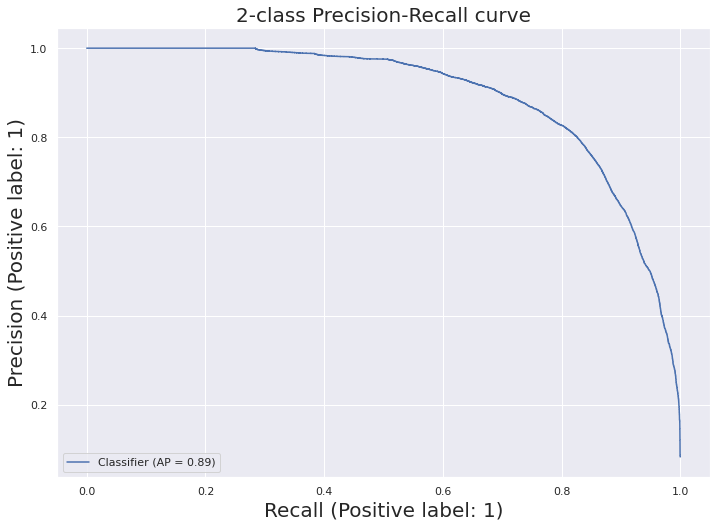

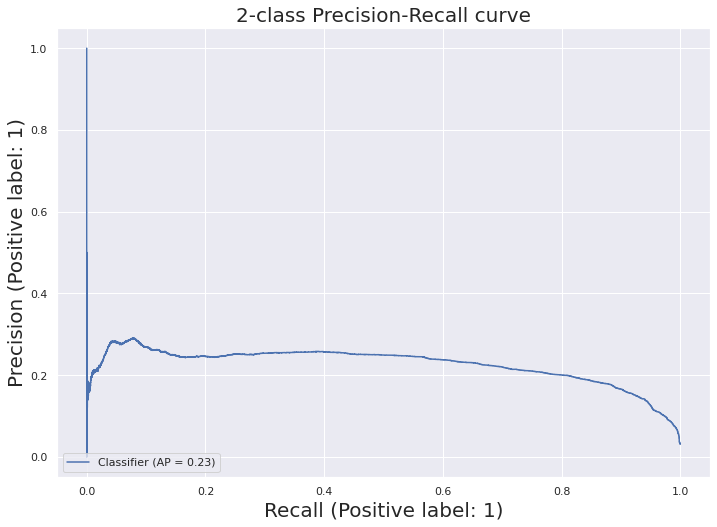

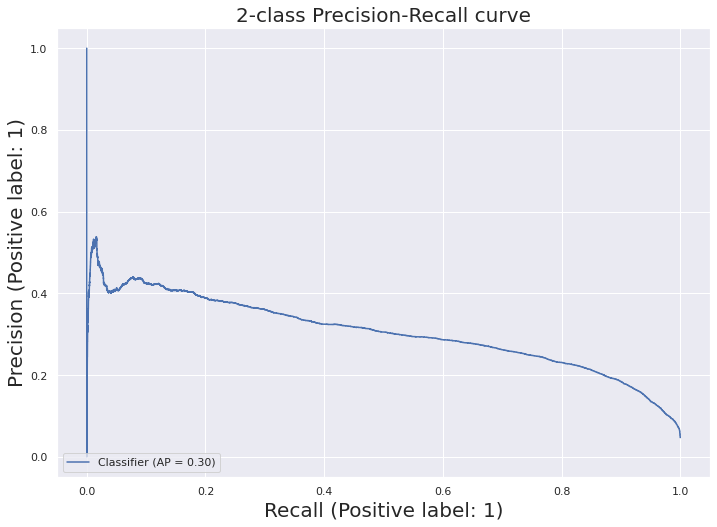

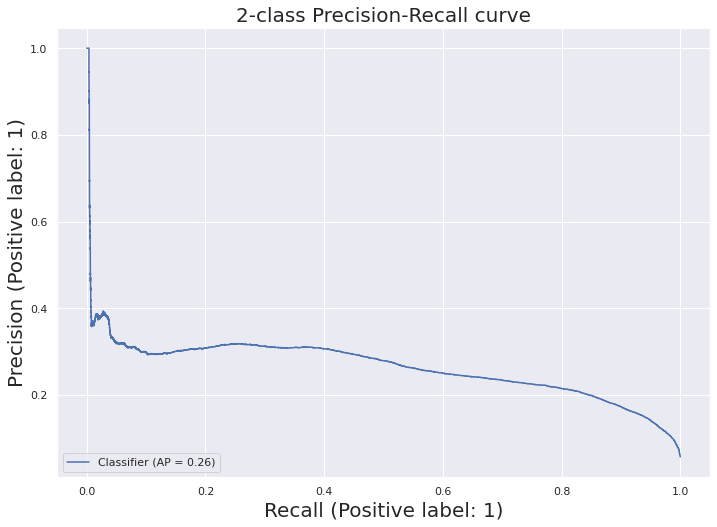

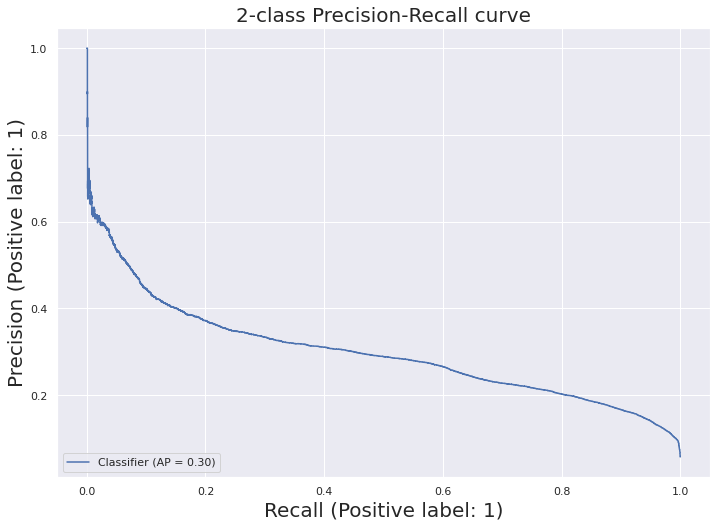

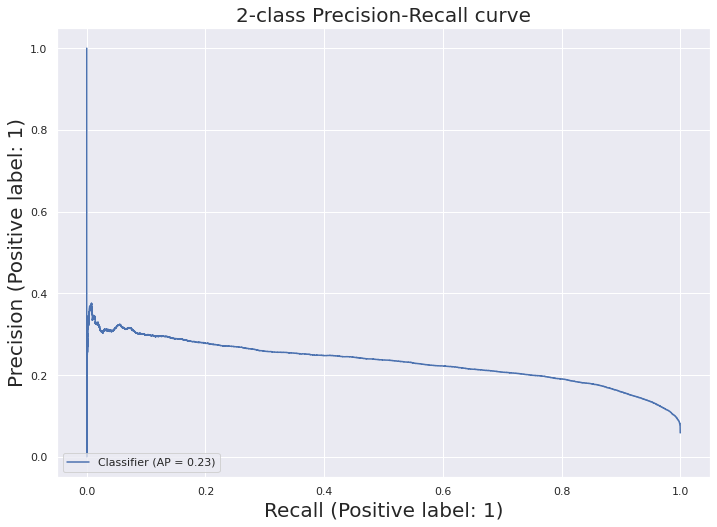

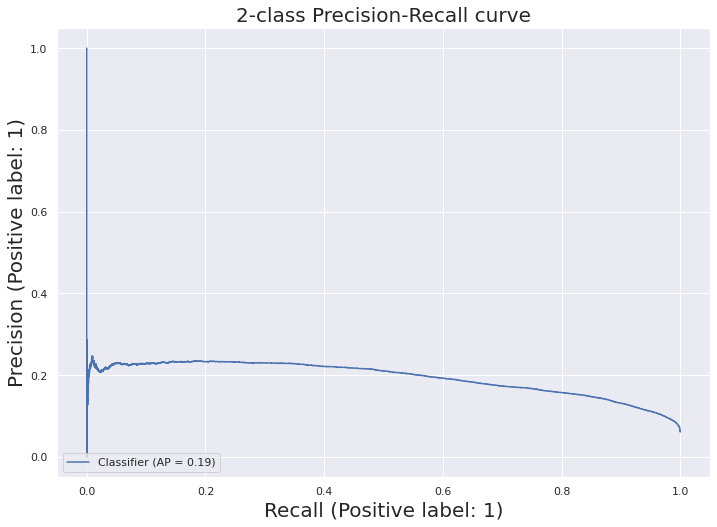

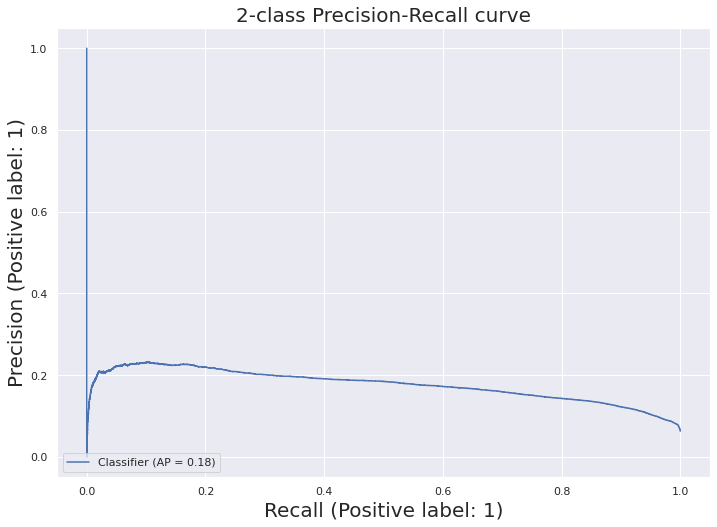

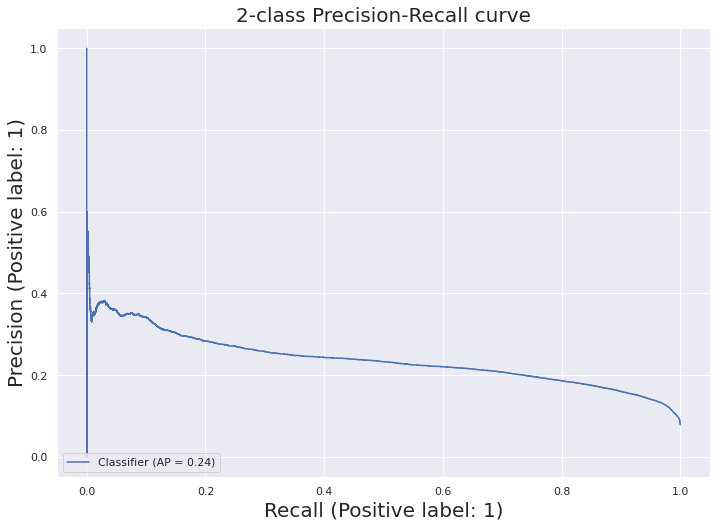

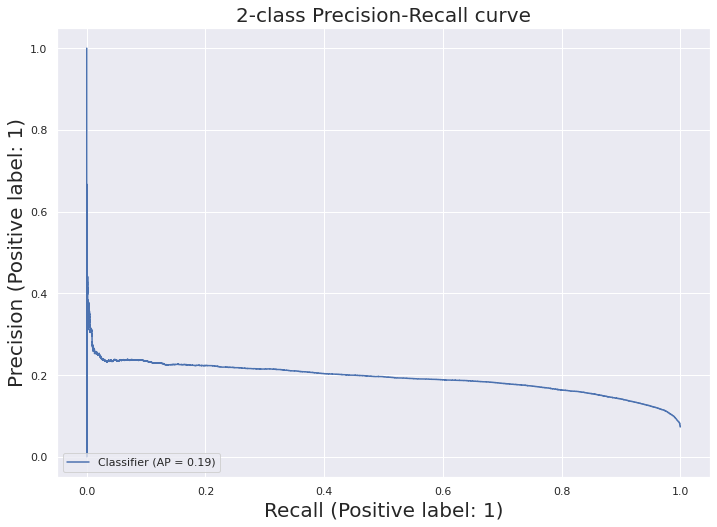

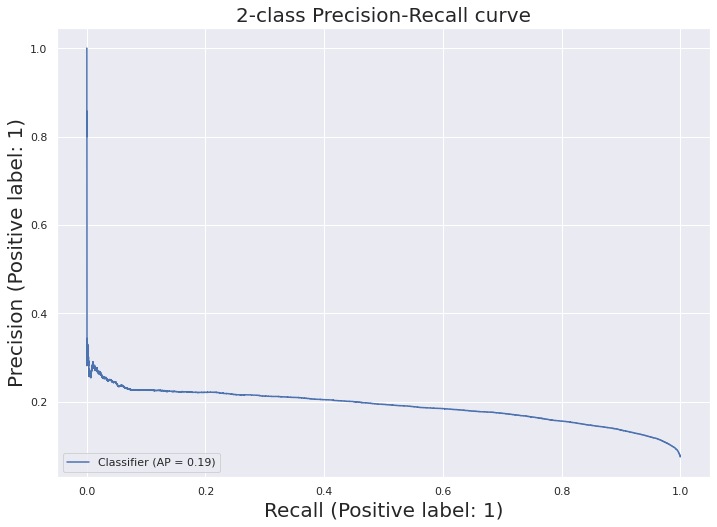

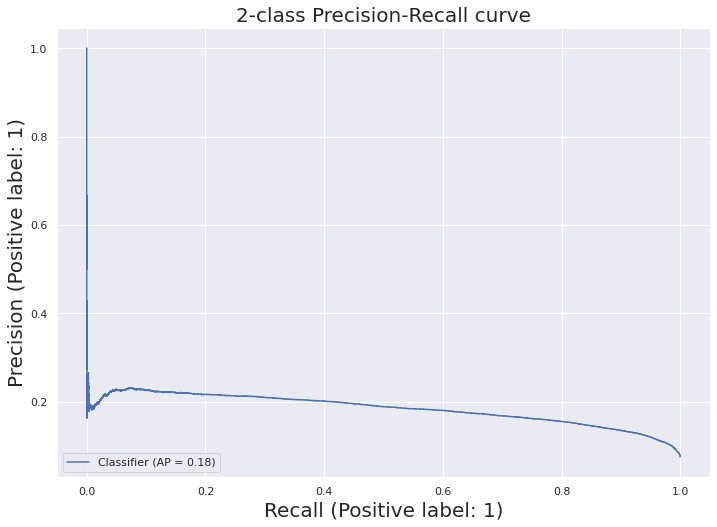

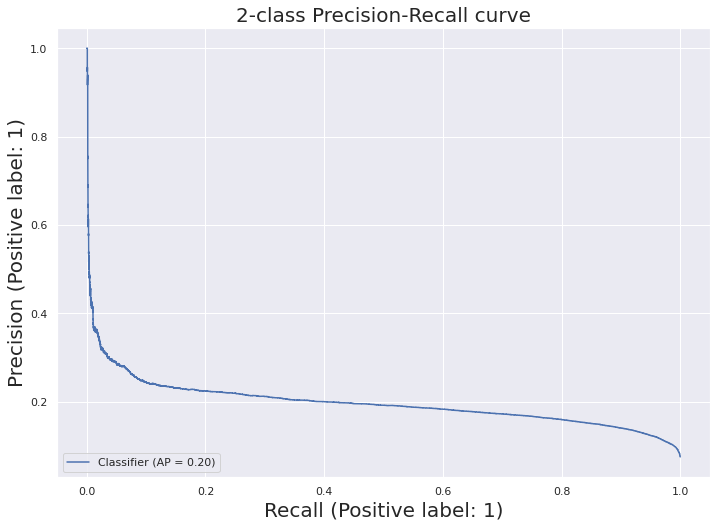

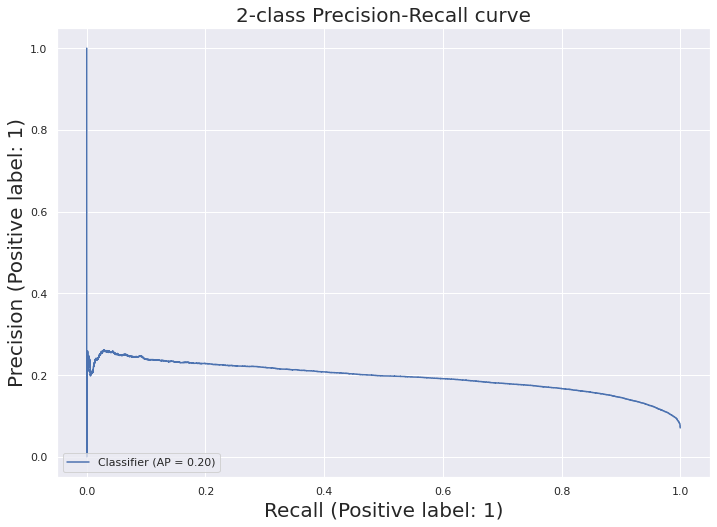

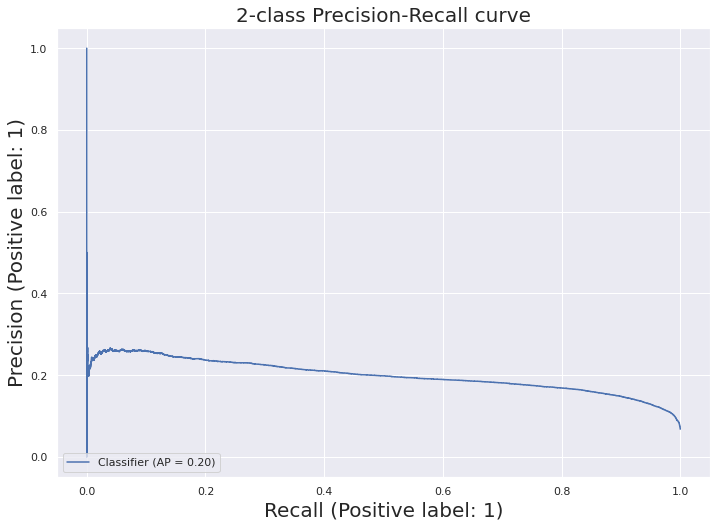

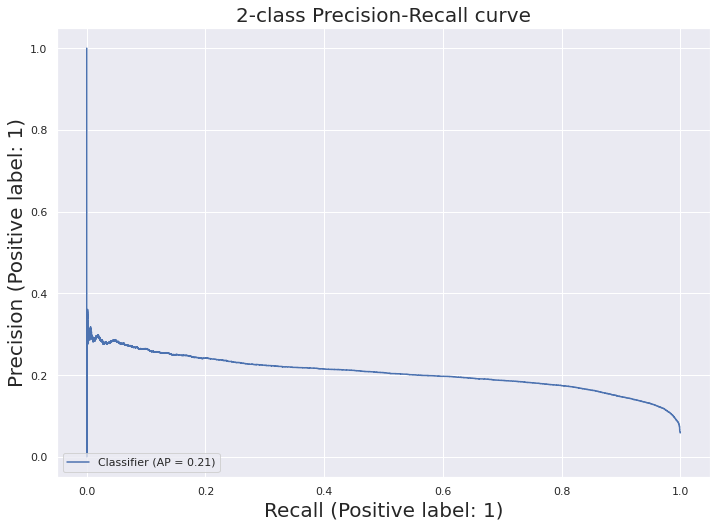

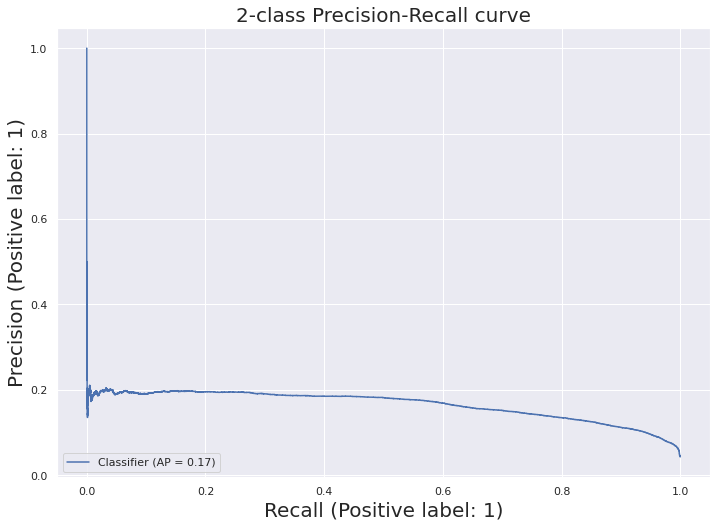

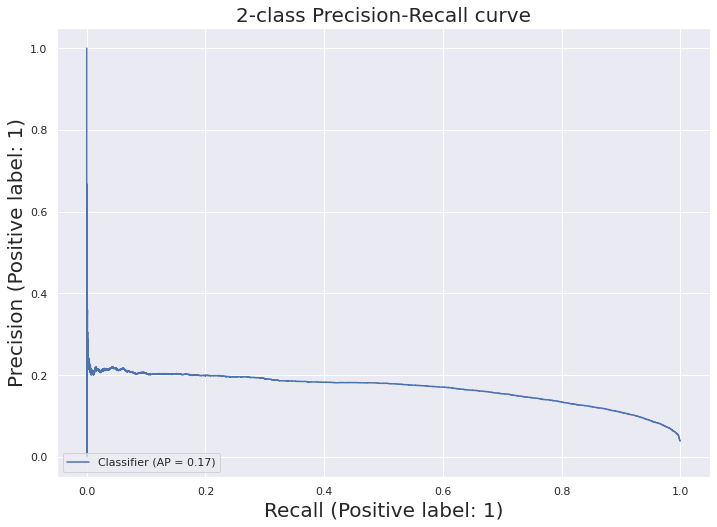

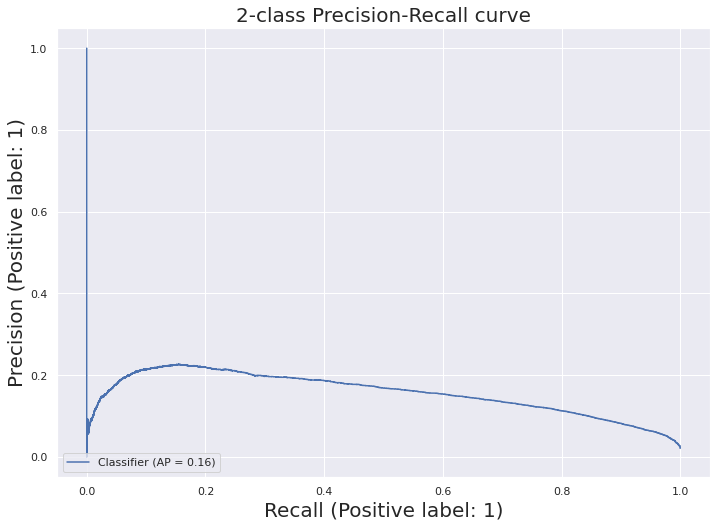

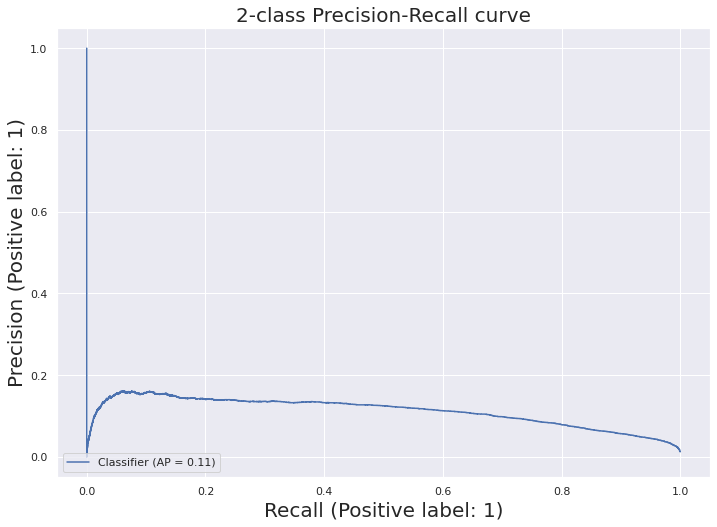

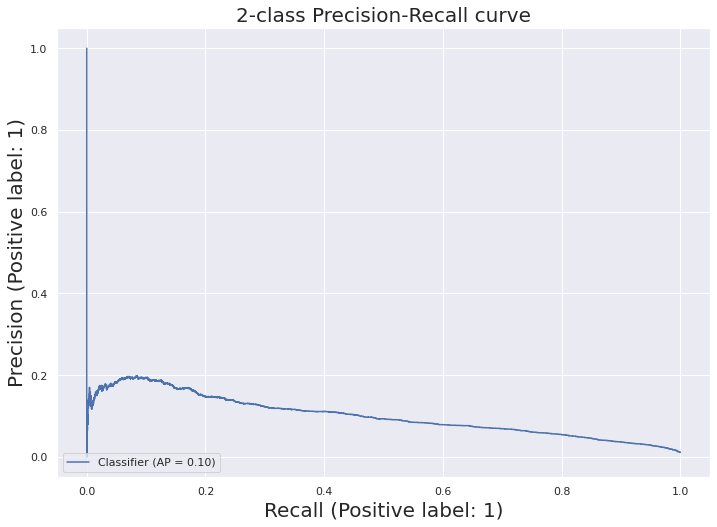

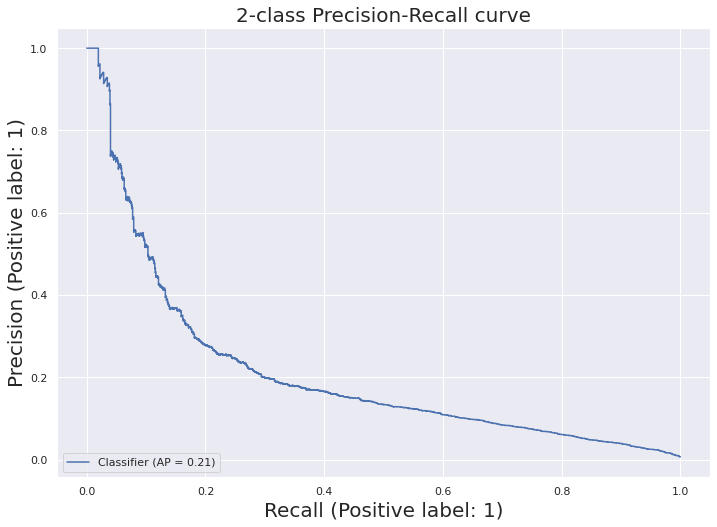

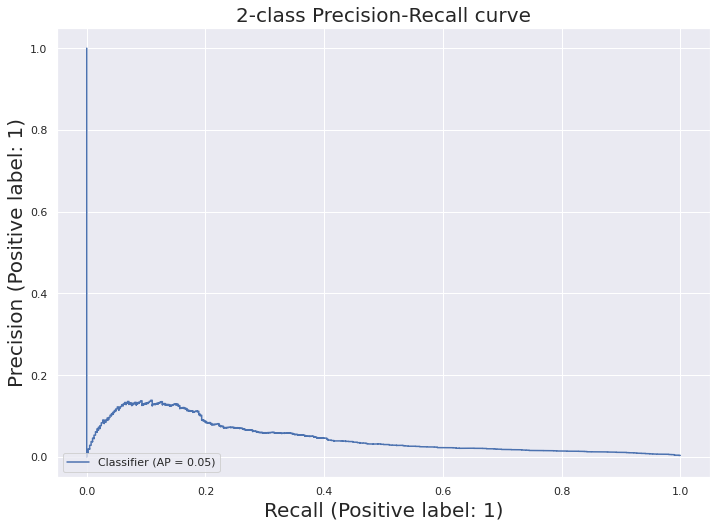

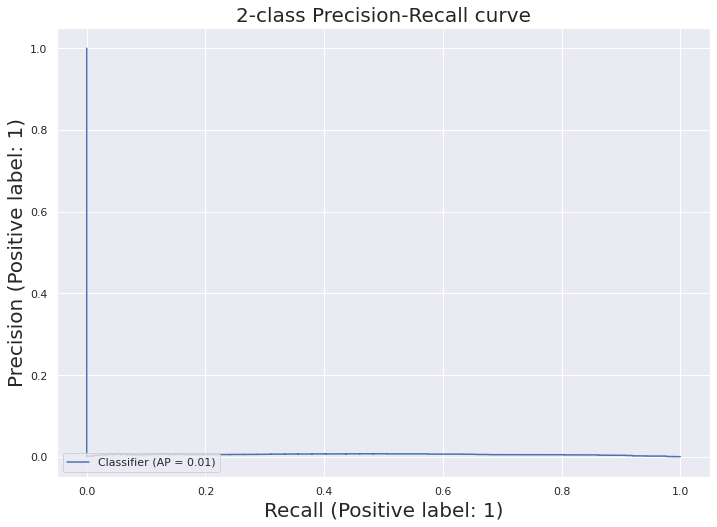

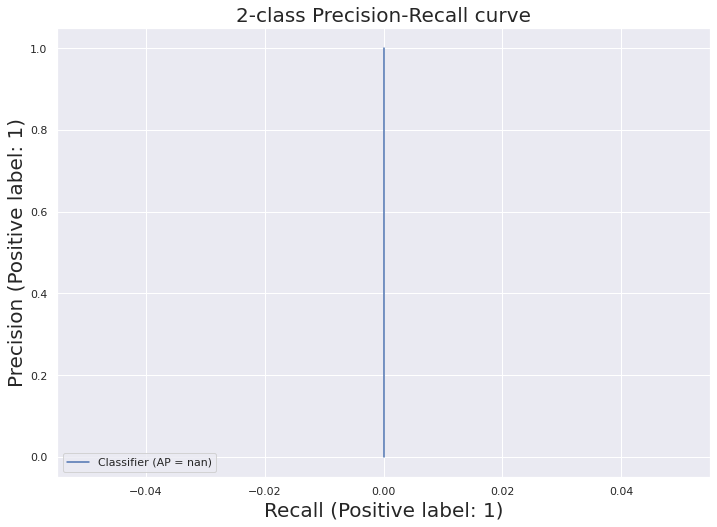

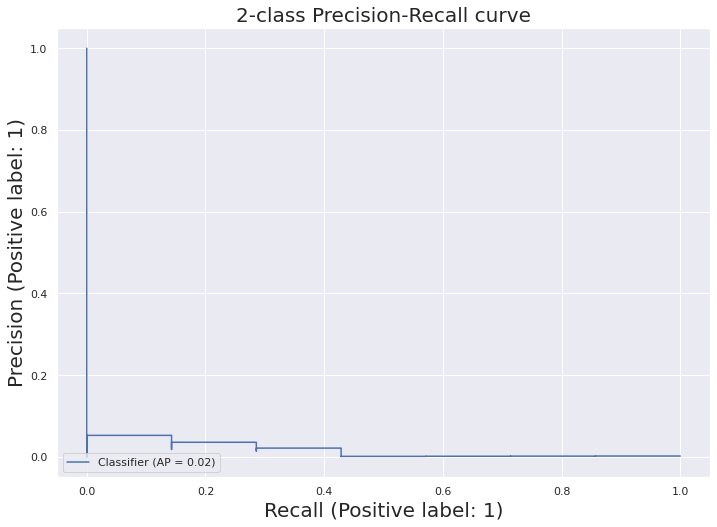

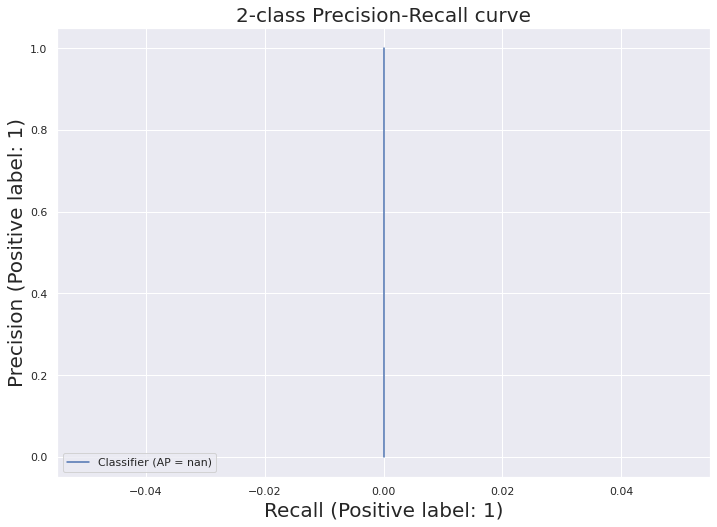

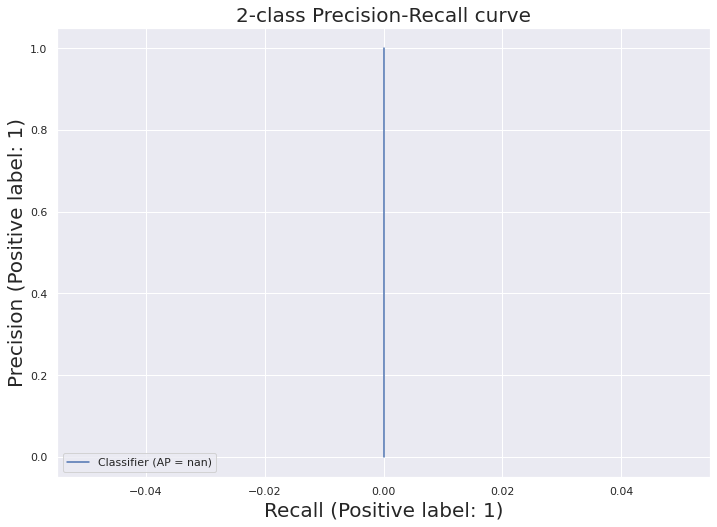

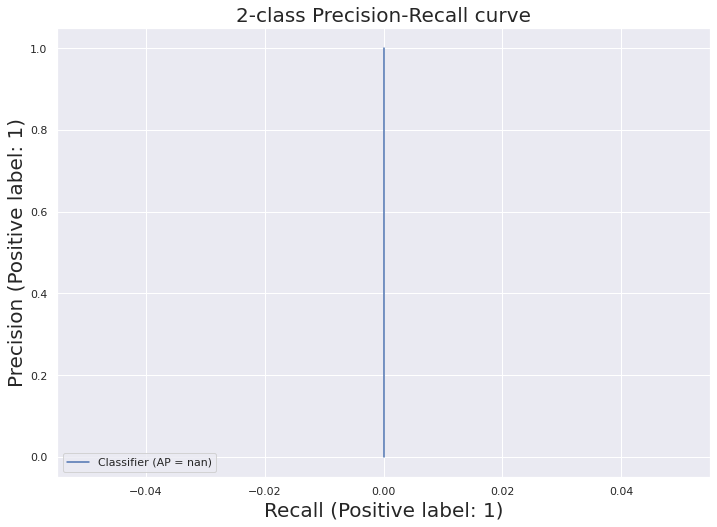

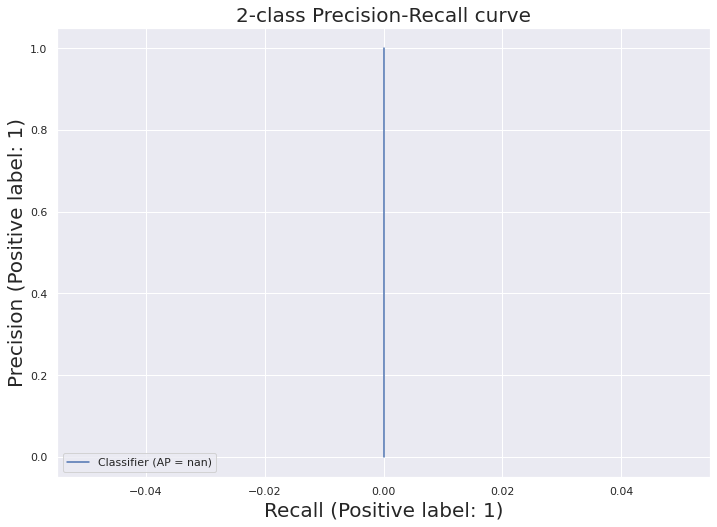

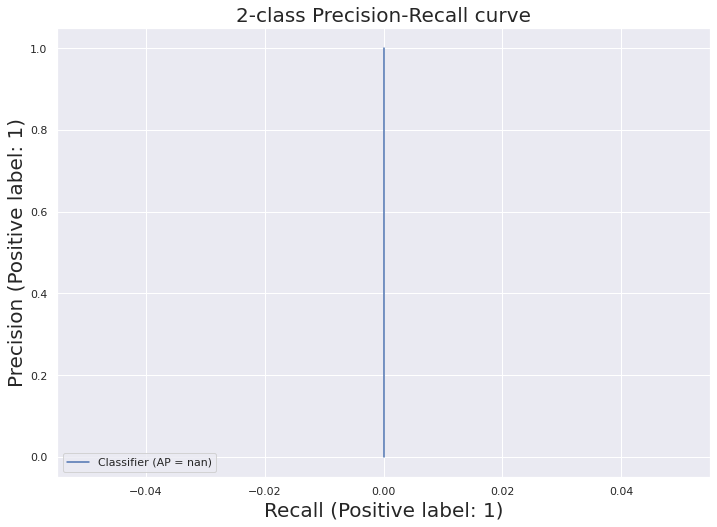

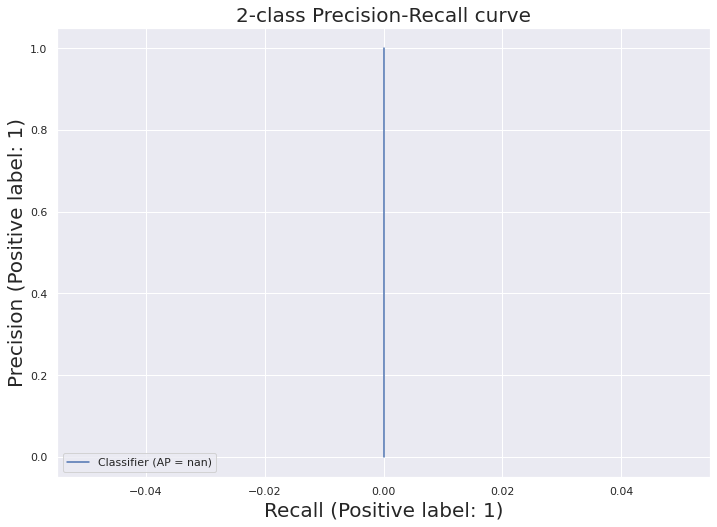

In [20]:
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_context("paper")

sns.set(rc={'figure.figsize' : (11.7, 8.27),
       'axes.labelsize': 20,
       'axes.titlesize': 20
       }
   )

colors = sns.color_palette("crest", 32)
for i in range(32):
    
    display = PrecisionRecallDisplay.from_predictions(y_true_ohe[:, i], y_pred[:, i], pos_label=1)
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [58]:
xx = torch.load("../hugginface-genomics2/o2/x_0.pt").numpy()
y_true = torch.load("../hugginface-genomics2/o2/y_true_0.pt")
y_pred = myexp(torch.load("../hugginface-genomics2/o2/1_y_pred_0.pt")).squeeze(0).numpy()

y_true_ohe = F.one_hot(y_true.long(), 32).squeeze(0).numpy()

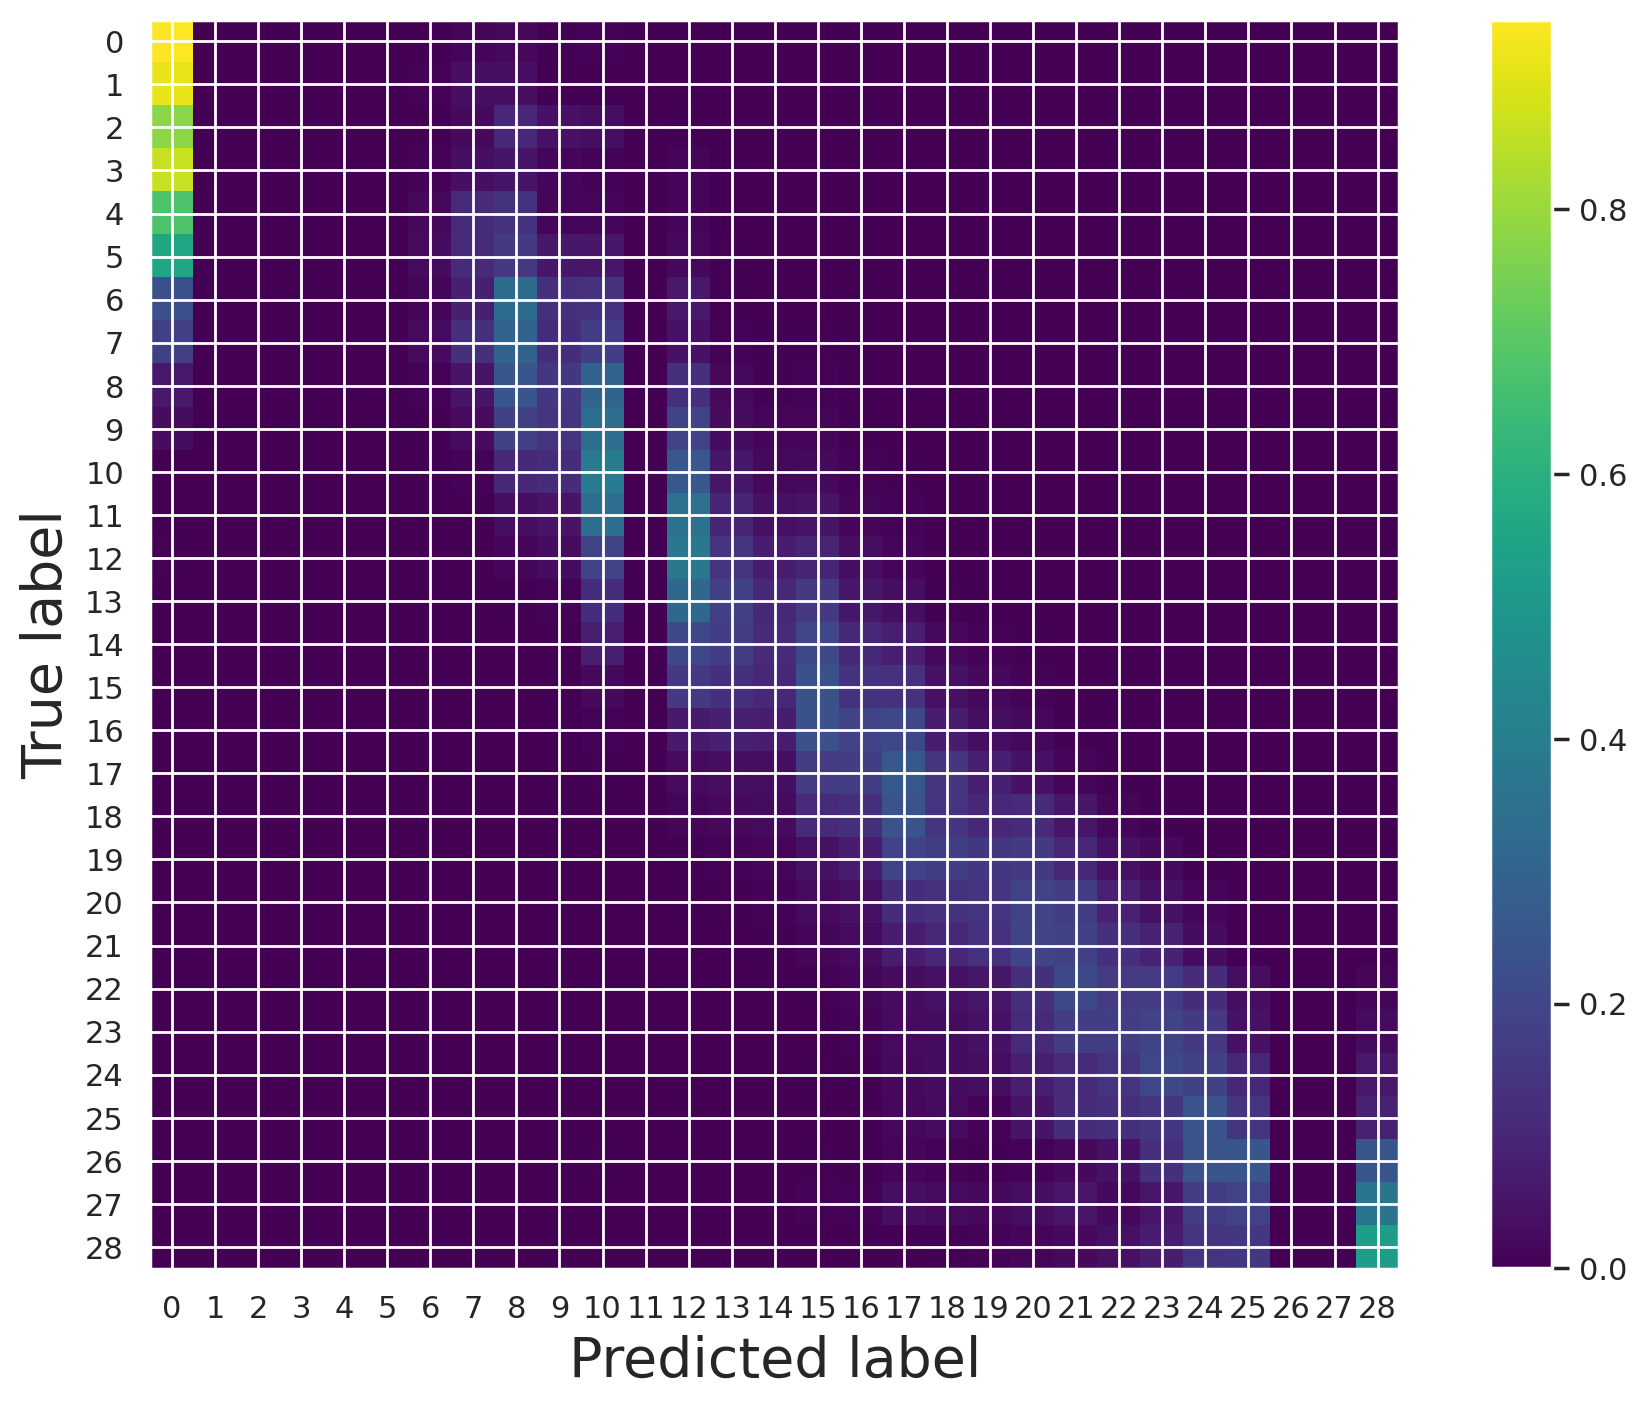

In [59]:
ConfusionMatrixDisplay.from_predictions(y_true.squeeze(0).long(),
                                        np.argmax(y_pred, axis=1).astype(np.long),
                                        include_values=False, 
                                       normalize='true')